| Run | Description                                  | Category        |
| --- | -------------------------------------------- | --------------- |
| R01 | Eyes open (baseline)                         | Rest            |
| R02 | Eyes closed (baseline)                       | Rest            |
| R03 | Move left fist                               | Motor execution |
| R04 | Move right fist                              | Motor execution |
| R05 | Move both fists                              | Motor execution |
| R06 | Move both feet                               | Motor execution |
| R07 | Imagine left fist                            | Motor imagery   |
| R08 | Imagine right fist                           | Motor imagery   |
| R09 | Imagine both fists                           | Motor imagery   |
| R10 | Imagine both feet                            | Motor imagery   |
| R11 | **Repeat of R03** (move left fist again)     | Motor execution |
| R12 | **Repeat of R04** (move right fist again)    | Motor execution |
| R13 | **Repeat of R07** (imagine left fist again)  | Motor imagery   |
| R14 | **Repeat of R08** (imagine right fist again) | Motor imagery   |




///////////////////////////////////////////////////////////////////////////////


| **Channel**                            | **Brain Region**                | **Main Function / What It Measures**                         |
| -------------------------------------- | ------------------------------- | ------------------------------------------------------------ |
| **Fp1, Fpz, Fp2**                      | Frontopolar (front of forehead) | Detects eye movement, attention, and frontal brain activity. |
| **Af7, Af3, Afz, Af4, Af8**            | Anterior Frontal                | Measures decision-making, focus, and emotional responses.    |
| **F7, F5, F3, F1, Fz, F2, F4, F6, F8** | Frontal                         | Involved in thinking, reasoning, and motor control.          |
| **Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6**  | Fronto-Central                  | Between frontal and central — involved in planning movement. |
| **C5, C3, C1, Cz, C2, C4, C6**         | Central                         | Main motor and sensory areas (movement and touch).           |
| **Cp5, Cp3, Cp1, Cpz, Cp2, Cp4, Cp6**  | Centro-Parietal                 | Combines movement and sensory processing information.        |
| **Ft7, Ft8**                           | Fronto-Temporal                 | Speech and auditory processing (language areas).             |
| **T7, T8, T9, T10**                    | Temporal                        | Hearing, speech, and memory processing.                      |
| **Tp7, Tp8**                           | Temporo-Parietal                | Integration of visual and auditory information.              |
| **P7, P5, P3, P1, Pz, P2, P4, P6, P8** | Parietal                        | Sensory processing, attention, and spatial orientation.      |
| **Po7, Po3, Poz, Po4, Po8**            | Parieto-Occipital               | Combines vision and spatial perception.                      |
| **O1, Oz, O2**                         | Occipital                       | Main visual processing region (vision and light perception). |
| **Iz**                                 | Inion (back of head)            | Reference near occipital area; vision-related.               |


In [ ]:
# Uncomment to install in a fresh runtime (e.g., Colab)
!pip install mne --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import time
from google.colab import drive
import shutil
import mne
import glob
from collections import defaultdict


In [ ]:
# --- Configuration and Setup (Fix included) ---

# 1) Mount Drive (already mounted, but good practice to call)
drive.mount('/content/drive', force_remount=False)

# Define file paths
DRIVE_ZIP_PATH = '/content/drive/MyDrive/EEG_dataset/physionet_mi_full.zip'
DRIVE_DATA_DIR = os.path.dirname(DRIVE_ZIP_PATH) # /content/drive/MyDrive/EEG_dataset

# Set the MNE data cache directory explicitly
mne_config_path = '/content/mne_data_cache'
mne.set_config('MNE_DATA', mne_config_path, set_env=True)

# FIX: Get the actual path from the config, ensuring it's a string
# We use the path we explicitly set above
LOCAL_CACHE_DIR = os.path.expanduser(mne_config_path) # The actual MNE download path

LOCAL_UNZIP_DIR = '/content/local_eeg_data/'
LOCAL_ZIP_PATH = '/content/physionet_mi_full.zip'

os.makedirs(DRIVE_DATA_DIR, exist_ok=True)
os.makedirs(LOCAL_UNZIP_DIR, exist_ok=True)

# Configuration: subjects and runs to load
SUBJECT_IDS = list(range(1, 110))
REQUIRED_RUNS = [7, 8, 9, 10, 13, 14]

# --- Phase 1: Check, Download, and Persist ZIP ---

def fetch_and_zip_dataset(subj_ids, runs, drive_zip_path, local_cache_dir):
    """
    Downloads all files using MNE (if ZIP is missing), zips the result,
    and saves the single ZIP file to Google Drive.
    """
    if os.path.exists(drive_zip_path):
        print("✅ Full ZIP file already exists on Drive. Skipping download/zip.")
        return True

    print("--- 1. FULL DATASET DOWNLOAD (SLOW, ONE-TIME OPERATION) ---")
    start_time = time.time()
    try:
        mne.datasets.eegbci.load_data(subj_ids, runs, path=local_cache_dir)
        print(f"✅ Download complete in {time.time() - start_time:.2f} seconds.")
    except Exception as e:
        print(f"Error during MNE download: {e}")
        return False

    # MNE stores data inside a sub-folder
    source_dir = os.path.join(local_cache_dir, 'MNE-eegbci-data')

    if not os.path.isdir(source_dir):
        print(f"Error: MNE data folder not found at {source_dir}. Check download process.")
        return False

    print("--- 2. ZIPPING DATASET ---")
    # Zip the entire folder on the fast local disk
    start_time = time.time()
    # -r for recursive, -q for quiet, the folder is zipped from its parent directory
    # The zip command requires us to specify the *target directory* inside the zip.
    parent_dir = os.path.dirname(source_dir)
    !cd "$parent_dir" && zip -r -q "$LOCAL_ZIP_PATH" "MNE-eegbci-data"
    print(f"✅ Zipping complete in {time.time() - start_time:.2f} seconds.")

    print("--- 3. PERSISTING ZIP TO DRIVE ---")
    start_time = time.time()
    !cp "$LOCAL_ZIP_PATH" "$drive_zip_path"
    print(f"✅ Copy to Drive complete in {time.time() - start_time:.2f} seconds.")

    # Clean up the large local files
    shutil.rmtree(local_cache_dir, ignore_errors=True)
    os.remove(LOCAL_ZIP_PATH)

    return True

# --- EXECUTE THE CHECK & DOWNLOAD/ZIP/PERSIST FLOW ---
if not fetch_and_zip_dataset(SUBJECT_IDS, REQUIRED_RUNS, DRIVE_ZIP_PATH, LOCAL_CACHE_DIR):
    raise Exception("Initial dataset setup failed. Cannot proceed.")

# --- Phase 2: Fast Loading (Runs Every Session) ---

def load_entire_dataset_fast(drive_zip_path, local_unzip_dir):
    """
    Copies the single large ZIP file from Drive to local disk, then unzips it.
    """

    # Define the base path expected after the first layer of unzipping
    BASE_UNZIPPED_PATH = os.path.join(local_unzip_dir, 'MNE-eegbci-data')

    # 1. Check if the files are already available locally (fast check)
    # MODIFIED: Use glob to recursively find the S001 folder to determine the correct nested path.
    # The ** enables searching in all subdirectories.
    found_s001_path = glob.glob(os.path.join(BASE_UNZIPPED_PATH, '**/S001'), recursive=True)

    if found_s001_path:
        # If S001 is found, the parent directory is the correct data path
        FAST_DATA_PATH = os.path.dirname(found_s001_path[0])
        print(f"\n✅ Data already found in local cache. FAST_DATA_PATH set to: {FAST_DATA_PATH}")
        return FAST_DATA_PATH

    # Check if data is already extracted in the local cache
    FAST_DATA_SUBPATH = os.path.join(local_unzip_dir, 'MNE-eegbci-data')
    if os.path.exists(FAST_DATA_SUBPATH) and os.listdir(FAST_DATA_SUBPATH):
        print(f"\n✅ Data already found in local cache: {FAST_DATA_SUBPATH}. Skipping transfer.")
        return FAST_DATA_SUBPATH

    print(f"\n--- FAST TRANSFER FROM DRIVE ({DRIVE_ZIP_PATH}) ---")
    os.makedirs(local_unzip_dir, exist_ok=True)

    # A. Copy ZIP from Drive to Local Colab Disk
    start_time = time.time()
    !cp "$drive_zip_path" "$LOCAL_ZIP_PATH"
    copy_time = time.time()
    print(f"✅ Copy Complete in {copy_time - start_time:.2f} seconds.")

    # B. Unzip Data on Local Disk
    print("Starting fast local unzipping...")
    !unzip -q "$LOCAL_ZIP_PATH" -d "$local_unzip_dir"

    unzip_time = time.time()
    print(f"✅ Unzip Complete in {unzip_time - copy_time:.2f} seconds.")

    # C. Clean Up
    !rm "$LOCAL_ZIP_PATH"
    print("Local ZIP file removed.")

    # D. Find and return the CORRECT final path after unzipping
    found_s001_path_after_unzip = glob.glob(os.path.join(BASE_UNZIPPED_PATH, '**/S001'), recursive=True)

    if not found_s001_path_after_unzip:
        raise Exception("Fatal Error: Unzip succeeded, but 'S001' folder could not be located in the local structure. Check your ZIP content structure.")

    FAST_DATA_PATH = os.path.dirname(found_s001_path_after_unzip[0])

    return FAST_DATA_PATH
# Execute the fast load
FAST_DATA_PATH = load_entire_dataset_fast(DRIVE_ZIP_PATH, LOCAL_UNZIP_DIR)

print(f"\nAll data is ready for fast processing from: {FAST_DATA_PATH}")

Mounted at /content/drive
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
✅ Full ZIP file already exists on Drive. Skipping download/zip.

--- FAST TRANSFER FROM DRIVE (/content/drive/MyDrive/EEG_dataset/physionet_mi_full.zip) ---
✅ Copy Complete in 16.23 seconds.
Starting fast local unzipping...
✅ Unzip Complete in 24.67 seconds.
Local ZIP file removed.

All data is ready for fast processing from: /content/local_eeg_data/MNE-eegbci-data/files/eegmmidb/1.0.0


In [ ]:
# --- Load EDF into MNE Raw objects (one raw per run), using the FAST LOCAL storage ---

def get_local_physionet_paths(base_path, subj, runs):
    """
    Generates file paths for a subject directly from the local unzipped directory
    using the standard PhysioNet naming convention.
    """
    local_files = []
    for run in runs:
        subj_dir = f'S{subj:03d}'
        # The file name is SNNNRMM.edf (e.g., S001R07.edf)
        filename = f'S{subj:03d}R{run:02d}.edf'
        fpath = os.path.join(base_path, subj_dir, filename)

        # This check is now extremely fast because it's local I/O
        if os.path.exists(fpath):
            local_files.append(fpath)

    return sorted(local_files)


raw_all = [] # list of dicts: {'subject': int, 'run': int, 'filepath': str, 'raw': Raw}

print("Starting FAST file reading and MNE loading...")

for subj in SUBJECT_IDS:
    # 1. Get the file paths from the FAST LOCAL DISK
    local_files = get_local_physionet_paths(FAST_DATA_PATH, subj, REQUIRED_RUNS)

    if not local_files:
        print(f"Warning: No local files found for subject {subj} at {FAST_DATA_PATH}. Skipping.")
        continue

    # 2. Iterate and process
    for fpath, run in zip(local_files, REQUIRED_RUNS):
        try:
            # THIS MNE READING IS NOW BOUND BY SSD SPEED, NOT NETWORK LATENCY
            raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=None, verbose=False)

            # Standardize channel names
            raw.rename_channels({ch: ch.strip().upper().replace('.', '') for ch in raw.ch_names})

            raw_all.append({
                'subject': subj,
                'run': run,
                'filepath': fpath,
                'raw': raw
            })
        except Exception as e:
            print(f"Failed loading {fpath}: {e}")

print(f"\nTotal runs loaded successfully: {len(raw_all)}")

Starting FAST file reading and MNE loading...


/tmp/ipython-input-3901078494.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=None, verbose=False)
/tmp/ipython-input-3901078494.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=None, verbose=False)
/tmp/ipython-input-3901078494.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=None, verbose=False)
/tmp/ipython-input-3901078494.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=None, verbose=False)
/tmp/ipython-input-3901078494.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(fpath, preload=True, stim_channel=N


Total runs loaded successfully: 654


In [ ]:
raw

<RawEDF | S109R14.edf, 64 x 19680 (123.0 s), ~9.7 MiB, data loaded>

In [ ]:
raw_all[0]

{'subject': 1,
 'run': 7,
 'filepath': '/content/local_eeg_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf',
 'raw': <RawEDF | S001R07.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>}

In [ ]:
raw.ch_names

['FC5',
 'FC3',
 'FC1',
 'FCZ',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'C3',
 'C1',
 'CZ',
 'C2',
 'C4',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPZ',
 'CP2',
 'CP4',
 'CP6',
 'FP1',
 'FPZ',
 'FP2',
 'AF7',
 'AF3',
 'AFZ',
 'AF4',
 'AF8',
 'F7',
 'F5',
 'F3',
 'F1',
 'FZ',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'T9',
 'T10',
 'TP7',
 'TP8',
 'P7',
 'P5',
 'P3',
 'P1',
 'PZ',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POZ',
 'PO4',
 'PO8',
 'O1',
 'OZ',
 'O2',
 'IZ']

In [ ]:
# Settings
PLOT_SECONDS = 10.0  # seconds to plot for raw signals
PSD_FMIN, PSD_FMAX = 1.0, 50.0
TOP_FREQ_BANDS = {'mu': (8, 13), 'beta': (13, 30)}

# Helper function to get concatenated Raw for a subject from raw_all
def get_concatenated_raw_for_subject_from_raw_all(subj_id, all_raw_data_list):
    raws_for_subj = [rec['raw'] for rec in all_raw_data_list if rec['subject'] == subj_id]
    if not raws_for_subj:
        raise ValueError(f"No raw data found for subject {subj_id} in raw_all.")

    if len(raws_for_subj) == 1:
        return raws_for_subj[0]
    else:
        # Before concatenating, ensure channels are consistent and types are set
        # This part might need to be robustified if channel names/types differ widely across runs
        for raw_obj in raws_for_subj:
            # Standardize channel names (as done in Cell 3 already)
            raw_obj.rename_channels({ch: ch.strip().upper().replace('.', '') for ch in raw_obj.ch_names})
            # Ensure EEG channel types where appropriate
            for ch in raw_obj.ch_names:
                try:
                    if raw_obj.get_channel_types(picks=[ch])[0] != 'eeg':
                        raw_obj.set_channel_types({ch: 'eeg'})
                except Exception:
                    pass
            # Attempt to set a standard montage
            try:
                raw_obj.set_montage('standard_1020')
            except Exception:
                pass

        # Pick common channels before concatenation
        common_chs = sorted(set.intersection(*[set(r.ch_names) for r in raws_for_subj]))
        raws_common = [r.copy().pick_channels(common_chs) for r in raws_for_subj]

        print(f"Concatenating {len(raws_for_subj)} runs for subject {subj_id}")
        return mne.concatenate_raws(raws_common)

# %% Helper: get Raw for subject (EDF-first) and prepare it for plotting
def prepare_raw_for_plotting(subj, all_raw_data_list=None):
    if all_raw_data_list is None:
        global raw_all
        all_raw_data_list = raw_all

    raw = get_concatenated_raw_for_subject_from_raw_all(subj, all_raw_data_list)
    print(f"=== Preparing subject {subj} for plotting ===")
    return raw

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Concatenating 6 runs for subject 1
=== Preparing subject 1 for plotting ===
=== Time series for subject 1 ===
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


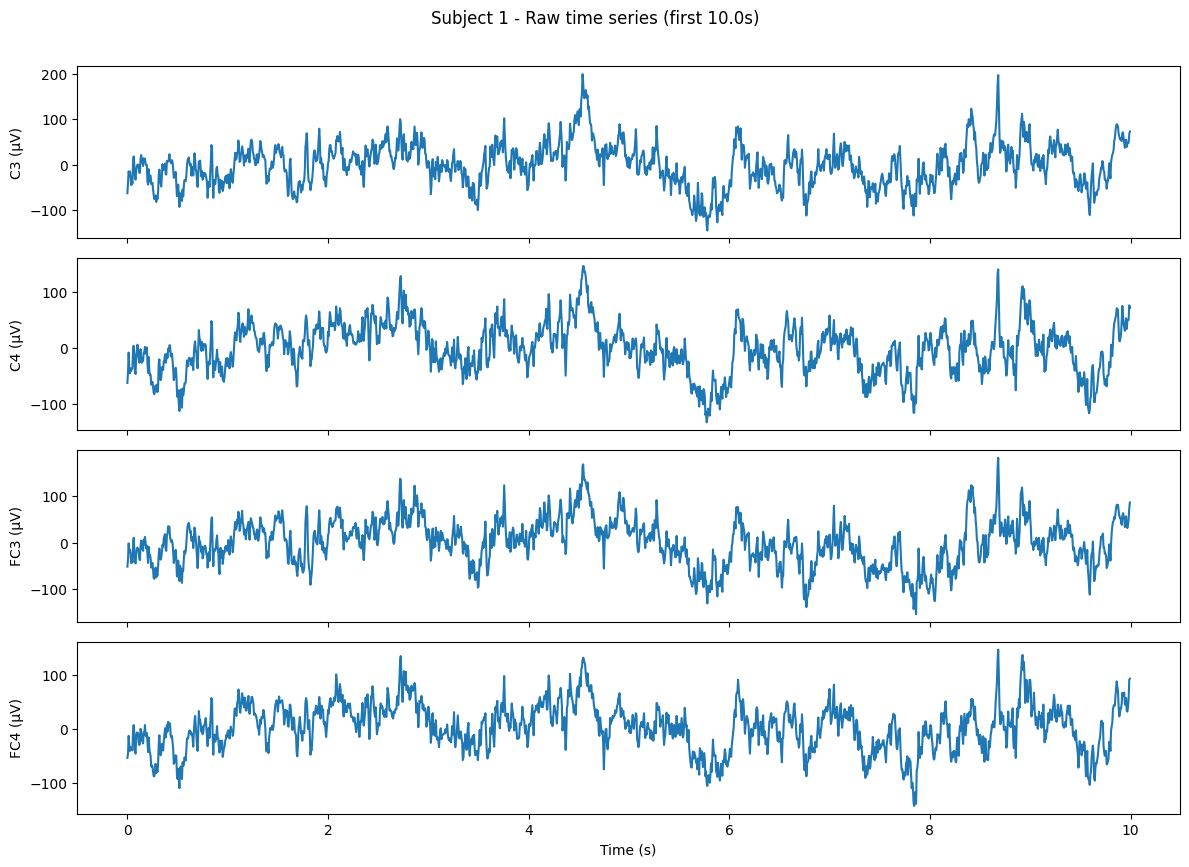

In [ ]:
def plot_time_series(subj, all_raw_data_list=None, channels=None):
    raw = prepare_raw_for_plotting(subj, all_raw_data_list=all_raw_data_list)
    print(f"=== Time series for subject {subj} ===")
    sfreq = raw.info['sfreq']
    n_plot_samples = int(min(PLOT_SECONDS * sfreq, raw.n_times))
    if channels is None:
        channels = [ch for ch in ['C3', 'C4', 'Cz', 'FC3', 'FC4', 'Pz'] if ch in raw.ch_names]
        if not channels:
            channels = raw.ch_names[:min(6, len(raw.ch_names))]
    data, times = raw.copy().pick_channels(channels).get_data(return_times=True)
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 2.2 * len(channels)), sharex=True)
    if len(channels) == 1:
        axes = [axes]
    for i, ch in enumerate(channels):
        axes[i].plot(times[:n_plot_samples], data[i, :n_plot_samples] * 1e6)
        axes[i].set_ylabel(ch + ' (µV)')
    axes[-1].set_xlabel('Time (s)')
    fig.suptitle(f'Subject {subj} - Raw time series (first {PLOT_SECONDS}s)')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

SUBJECT_TO_PLOT = 1
plot_time_series(SUBJECT_TO_PLOT, all_raw_data_list=raw_all)

#The plot you’ll see has:

#0–4 Hz → Delta waves → deep sleep

# 4–8 Hz → Theta waves → drowsy or light sleep

# 8–12 Hz → Alpha waves → relaxed, eyes closed

# 13–30 Hz → Beta waves → alert, active thinking

# 30–40 Hz → Low Gamma → higher-level processing

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Concatenating 6 runs for subject 1
=== Preparing subject 1 for plotting ===
=== PSD for subject 1 ===
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


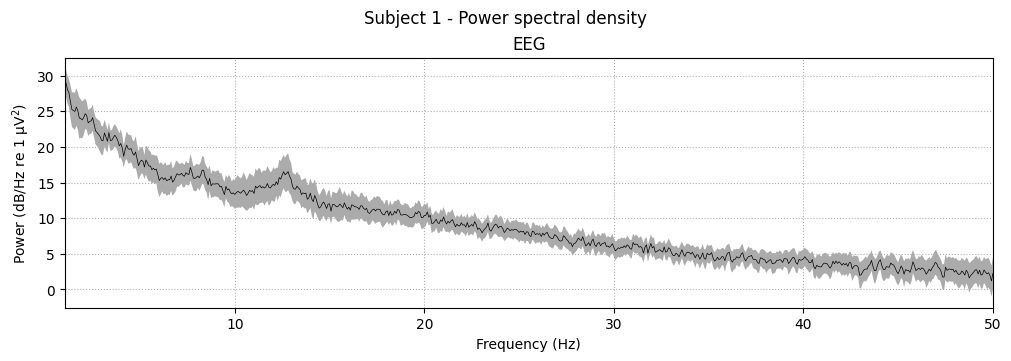

In [ ]:
# PSD plot (Welch) for the whole runing
def plot_psd(subj, all_raw_data_list=None, fmin=PSD_FMIN, fmax=PSD_FMAX):
    raw = prepare_raw_for_plotting(subj, all_raw_data_list=all_raw_data_list)
    print(f"=== PSD for subject {subj} ===")
    try:
        fig = raw.plot_psd(fmin=fmin, fmax=fmax, average=True, show=False)
        plt.suptitle(f'Subject {subj} - Power spectral density')
        plt.show()
    except Exception as e:
        print('PSD plotting failed:', e)
plot_psd(SUBJECT_TO_PLOT, all_raw_data_list=raw_all)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


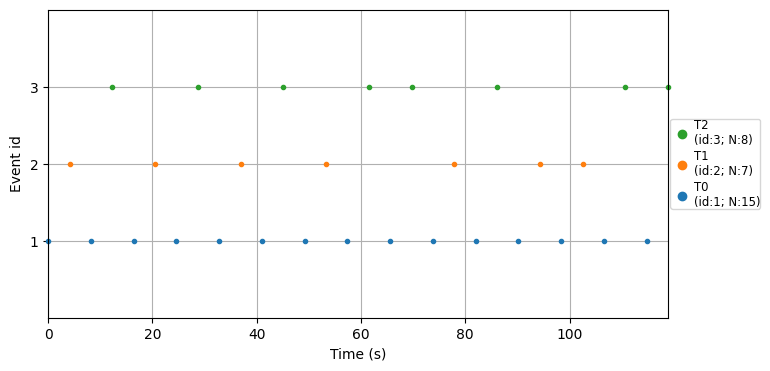

In [ ]:
events, event_id = mne.events_from_annotations(raw)

# Explicitly create figure and axes
fig, ax = plt.subplots(figsize=(10, 4))

# Plot events on the created axes
mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_id, axes=ax, show=False)

# Show the plot
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Concatenating 6 runs for subject 1
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Event ID mapping: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


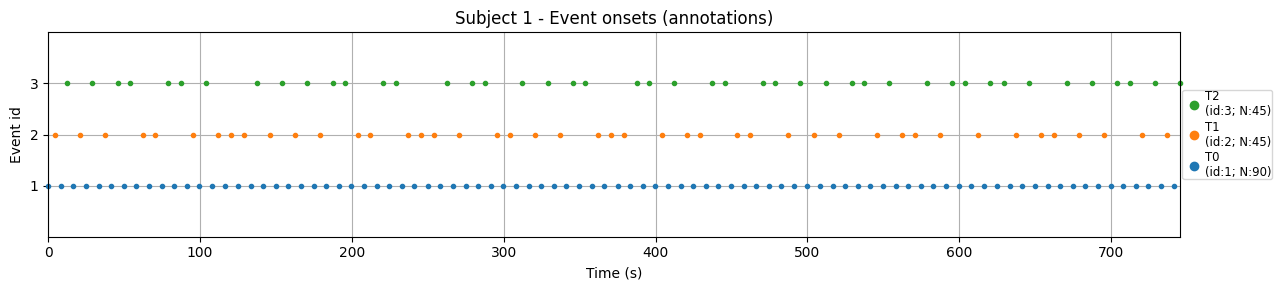

In [ ]:
# Use the subject we already picked (SUBJECT_TO_PLOT) or set a new path to a specific EDF
raw_for_events = get_concatenated_raw_for_subject_from_raw_all(SUBJECT_TO_PLOT, raw_all)


events, event_id = mne.events_from_annotations(raw_for_events)
print('Event ID mapping:', event_id)


fig, ax = plt.subplots(figsize=(12, 3))
mne.viz.plot_events(events, sfreq=raw_for_events.info['sfreq'], event_id=event_id, axes=ax, show=False)
ax.set_title(f'Subject {SUBJECT_TO_PLOT} - Event onsets (annotations)')
plt.tight_layout()
plt.show()

MNE only uses the onset — the start time — and ignores the duration.

So in the event plot (plot_events), you’ll only see a dot at the moment the event begins.
👉 annotations = start markers, not continuous signals.

| Label  | Meaning                  | Code |
| ------ | ------------------------ | ---- |
| `'T0'` | baseline or rest         | `1`  |
| `'T1'` | left-hand or target      | `2`  |
| `'T2'` | right-hand or non-target | `3`  |


T0, T1, T2 are cue markers, not actual movements.

The subject may not move — they only see or imagine movement.

Markers appear when the instruction/cue is shown (e.g., “imagine right hand”), not when movement happens.

So, even if the file is for the right hand, T1 (left-hand cue) may still appear because all cues are runed in the experiment.

In [ ]:
print(event_id)

{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


Channels to plot: ['C3', 'C4']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


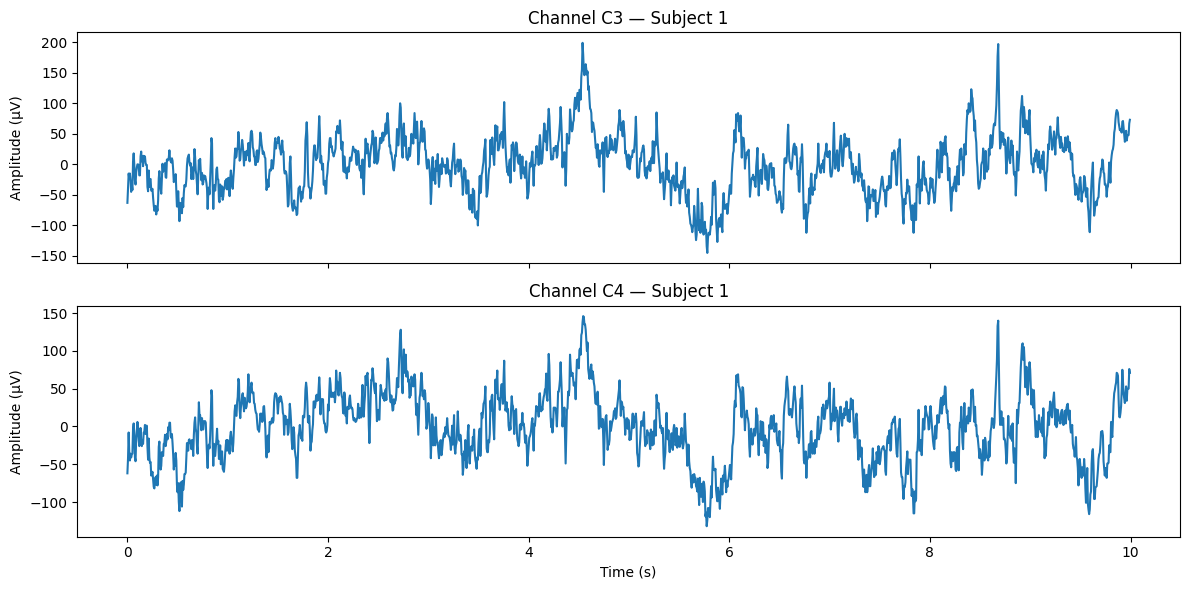

In [ ]:
picks = [ch for ch in ['C3', 'C4'] if ch in raw_for_events.ch_names]
if not picks:
    # try common variants
    picks = [ch for ch in raw_for_events.ch_names if ch.upper().startswith('C3') or ch.upper().startswith('C4')][:2]

print('Channels to plot:', picks)

sfreq = raw_for_events.info['sfreq']
start_s, duration_s = 0, 10
start_samp = int(start_s * sfreq)
stop_samp = int((start_s + duration_s) * sfreq)

# get_data returns array of shape (n_channels, n_times)
if picks:
    data = raw_for_events.copy().pick_channels(picks).get_data()
    times = np.arange(data.shape[1]) / sfreq
    fig, axes = plt.subplots(len(picks), 1, figsize=(12, 3 * len(picks)), sharex=True)
    if len(picks) == 1:
        axes = [axes]
    for i, ch in enumerate(picks):
        axes[i].plot(times[start_samp:stop_samp], data[i, start_samp:stop_samp] * 1e6)
        axes[i].set_title(f'Channel {ch} — Subject {SUBJECT_TO_PLOT}')
        axes[i].set_ylabel('Amplitude (µV)')
    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
else:
    print('No C3/C4-like channels found in this raw. Available channels (first 20):', raw_for_events.ch_names[:20])


# C3 --> left , C4 ---> right

In [ ]:
# Cell 14 - Quick EDA via DataFrame for a chosen runing (uses pandas via mne.to_data_frame)
# WARNING: converting long runings to DataFrame can be memory-heavy. Use a short segment if needed.

sample = raw_all[0]  # change index to inspect other files
print('Inspecting', sample['subject'], sample['run'])
raw_df = sample['raw'].to_data_frame()

print('\nDataFrame description:')
print(raw_df.describe())

# Basic interpreted diagnostics (prints similar to your notes)
n_samples = sample['raw'].n_times
duration_s = n_samples / sample['raw'].info['sfreq']
print(f"\nruning duration (s): {duration_s:.1f}, Samples: {n_samples}")
print('Channels:', len(sample['raw'].ch_names))

# Provide summary comments similar to your note
print('\nQuick diagnostics:')
print('- Counts per channel =', n_samples)
print('- Value ranges (min/max) appear biologically plausible; check for spikes > ±1000 µV')
print('- Means near zero are normal; large DC offsets may need detrending or high-pass filter')
print('- Std around 20-40 µV is typical; much larger may indicate noisy channel')

# Optionally show first few rows
print('\nFirst 5 rows (time + channels):')
print(raw_df.head())

Inspecting 1 7

DataFrame description:
               time           FC5           FC3          FC1           FCZ  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean      62.496875     -0.281550      1.669200      2.00100      2.524850   
std       36.085294     56.061835     53.726428     54.95929     56.057544   
min        0.000000   -249.000000   -253.000000   -268.00000   -267.000000   
25%       31.248438    -36.000000    -32.000000    -33.00000    -34.000000   
50%       62.496875     -1.000000      1.000000      1.00000      2.000000   
75%       93.745313     32.000000     34.000000     35.00000     37.000000   
max      124.993750    343.000000    282.000000    272.00000    291.000000   

                FC2           FC4           FC6           C5            C3  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       1.926450      2.418750      1.522350     -1.41555      1.432950   
std       55.903308     

In [ ]:
# Access first subject’s first runing
sample = raw_all[0] #S001 R07
raw = sample["raw"]  # Data that will be used in training model

# View info and annotations
print(sample["subject"], sample["run"])


1 7


In [ ]:
sample

{'subject': 1,
 'run': 7,
 'filepath': '/content/local_eeg_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf',
 'raw': <RawEDF | S001R07.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>}

In [ ]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCZ, FC2, FC4, FC6, C5, C3, C1, CZ, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

runing Info: Captured on August 12, 2009, at 16:15 UTC by an unknown experimenter, with the participant labeled X.

Acquisition Details: Data was runed at a sampling frequency of 160 Hz, meaning 160 data points per second were collected for each EEG channel.

Channels: The EEG setup included 64 electrodes, used to measure brain activity across different scalp regions.

Filters:

High-pass filter: 0.00 Hz (no lower frequency cutoff applied).

Low-pass filter: 80.00 Hz (signals above 80 Hz were filtered out to remove high-frequency noise).

Head & Sensor Digitization: Information about the 3D positions of electrodes was not available in this dataset.

In [ ]:
# Convert to DataFrame for EDA
df = raw.to_data_frame()
print(df.describe())

               time           FC5           FC3          FC1           FCZ  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean      62.496875     -0.281550      1.669200      2.00100      2.524850   
std       36.085294     56.061835     53.726428     54.95929     56.057544   
min        0.000000   -249.000000   -253.000000   -268.00000   -267.000000   
25%       31.248438    -36.000000    -32.000000    -33.00000    -34.000000   
50%       62.496875     -1.000000      1.000000      1.00000      2.000000   
75%       93.745313     32.000000     34.000000     35.00000     37.000000   
max      124.993750    343.000000    282.000000    272.00000    291.000000   

                FC2           FC4           FC6           C5            C3  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       1.926450      2.418750      1.522350     -1.41555      1.432950   
std       55.903308     50.510319     49.318776     55.32000   

✅ (a) Signal size and length

count = 19680 for all channels → the same number of time points → consistent runing length and synchronized channels.

✅ (b) Signal amplitude range

min and max are around -100 to +200 µV for most channels.
→ That’s normal EEG range, not extreme noise.

✅ (c) Mean values near zero

Example: mean for Fcz. ≈ 0.65, C3.. ≈ 1.38
→ EEG signals are centered around zero — no large DC offset (good sign).

✅ (d) Standard deviation (std)

Around 25–40 µV for most channels.
→ Indicates normal EEG variability — not completely flat, not excessively noisy.

✅ (e) Data integrity

All channels have the same count → no missing data.

Values are within biological limits (no spikes like ±1000 µV) → the signal seems clean and valid

📈 General Conclusions

✅ All channels have 19,680 samples → no missing or unequal data.

✅ Means are small (close to 0) → EEG properly referenced.

⚡ Std values between 20–30 µV → realistic brain signal range (not saturated).

⚠️ A few channels reach ±150 µV → some motion or blink artifacts may be present.

🧩 Duration ≈ 123 s (2 minutes) → consistent with one experimental run.

✅ In Short

Your dataset:

Contains 64 EEG channels + time column (65 total columns).

Covers ~2 minutes of brain activity.

Appears clean and balanced with normal EEG voltage ranges.

No missing or duplicated samples

# Before Cleaning

In [ ]:
import pandas as pd

# Store summary stats for all files
all_summaries = []

for rec in raw_all:
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"]

    # Convert to DataFrame
    df = raw.to_data_frame()

    # Compute statistics per channel
    stats = df.describe().transpose().reset_index()
    stats.rename(columns={"index": "channel"}, inplace=True)

    # Add identifiers
    stats["subject"] = subj
    stats["run"] = run

    all_summaries.append(stats)

# Combine all into one DataFrame
summary_df = pd.concat(all_summaries, ignore_index=True)

# Save or inspect
summary_df.to_csv("all_subjects_summary.csv", index=False)
print("✅ Summary saved for all subjects and runs (with channel names).")


✅ Summary saved for all subjects and runs (with channel names).


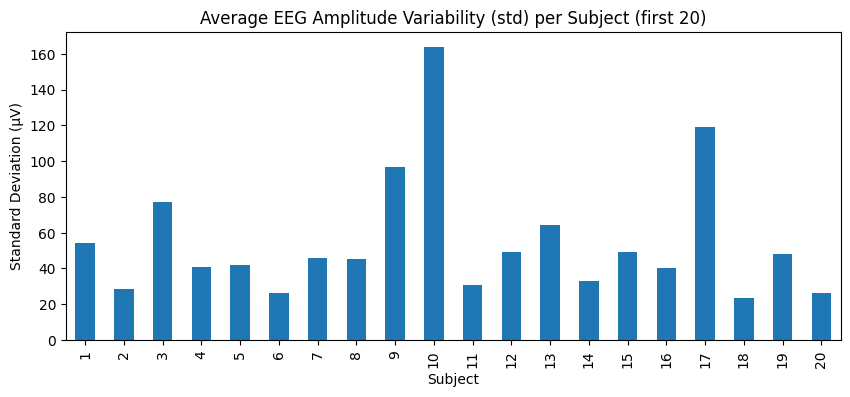

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

summary_df = pd.read_csv("all_subjects_summary.csv")

# Compute average std per subject
mean_std = summary_df.groupby("subject")["std"].mean()

# Keep only the first 20 subjects
mean_std = mean_std.iloc[:20]

# Plot
mean_std.plot(kind="bar", figsize=(10, 4))
plt.title("Average EEG Amplitude Variability (std) per Subject (first 20)")
plt.ylabel("Standard Deviation (µV)")
plt.xlabel("Subject")
plt.show()



average all channels all runs per subject

“Values above ~100 µV are likely noisy channels or runings.”

In [ ]:
noisy_channels = summary_df[summary_df["std"] > 100]


In [ ]:
noisy_channels

,channel,count,mean,std,min,25%,50%,75%,max,subject,run
22,FP1,20000.0,-10.607750,108.879522,-524.0,-61.0,-13.0,33.00,613.0,1,7
24,FP2,20000.0,-5.293400,102.966984,-516.0,-51.0,-7.0,36.00,592.0,1,7
152,FP1,20000.0,-13.752000,106.309668,-502.0,-67.0,-18.0,32.00,600.0,1,9
153,FPZ,20000.0,-12.616250,101.177912,-492.0,-60.0,-14.0,30.00,667.0,1,9
154,FP2,20000.0,-12.967800,100.996238,-494.0,-64.0,-16.0,29.00,633.0,1,9
...,...,...,...,...,...,...,...,...,...,...,...
42423,T9,19680.0,-12.759096,120.347367,-297.0,-75.0,-4.0,63.00,308.0,109,13
42424,T10,19680.0,32.566057,126.637992,-297.0,-23.0,48.0,110.25,306.0,109,13
42448,FC1,19680.0,-28.979014,111.238730,-302.0,-98.0,-25.0,49.00,297.0,109,14
42458,C4,19680.0,-41.226372,216.512050,-336.0,-264.0,-78.0,149.00,399.0,109,14


In [ ]:
filtered_df = summary_df[summary_df['subject']<=20]
filtered_df

,channel,count,mean,std,min,25%,50%,75%,max,subject,run
0,time,20000.0,62.496875,36.085294,0.0,31.248438,62.496875,93.745312,124.99375,1,7
1,FC5,20000.0,-0.281550,56.061835,-249.0,-36.000000,-1.000000,32.000000,343.00000,1,7
2,FC3,20000.0,1.669200,53.726428,-253.0,-32.000000,1.000000,34.000000,282.00000,1,7
3,FC1,20000.0,2.001000,54.959290,-268.0,-33.000000,1.000000,35.000000,272.00000,1,7
4,FCZ,20000.0,2.524850,56.057544,-267.0,-34.000000,2.000000,37.000000,291.00000,1,7
...,...,...,...,...,...,...,...,...,...,...,...
7795,PO8,19680.0,-1.621087,15.030544,-53.0,-12.000000,-2.000000,9.000000,55.00000,20,14
7796,O1,19680.0,0.361992,13.394030,-65.0,-8.000000,0.000000,8.000000,76.00000,20,14
7797,OZ,19680.0,-1.016260,11.940102,-62.0,-9.000000,-1.000000,7.000000,58.00000,20,14
7798,O2,19680.0,-0.020071,11.439324,-37.0,-8.000000,-1.000000,7.000000,71.00000,20,14


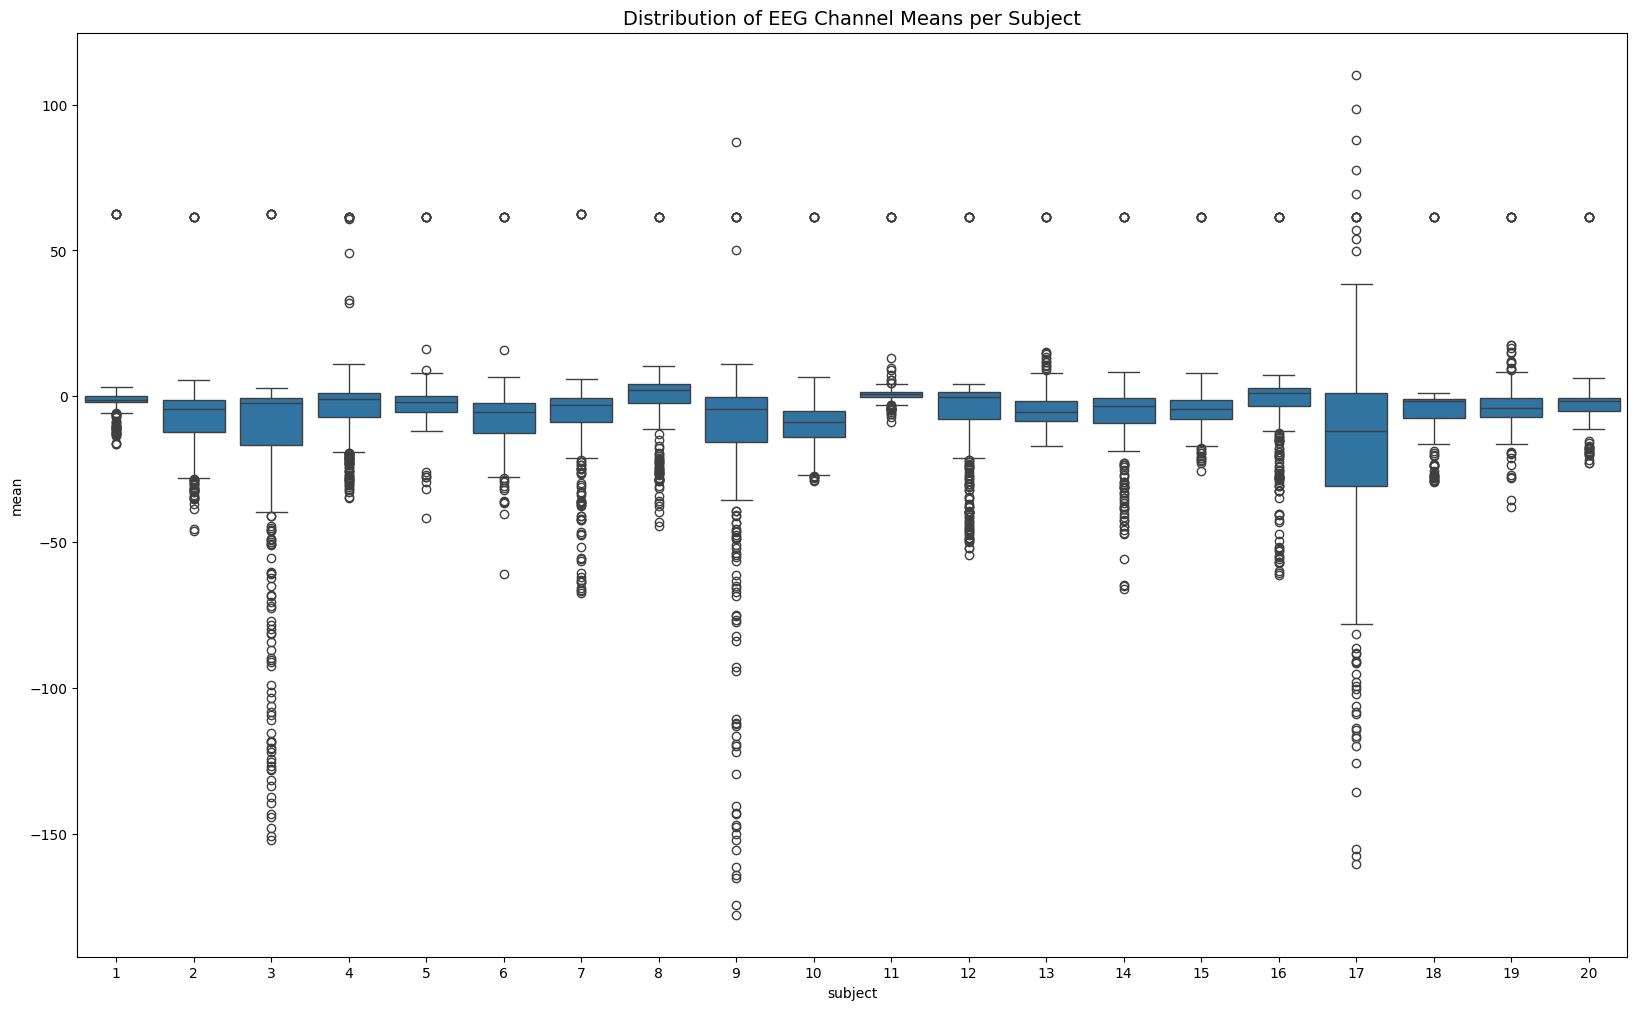

In [ ]:
plt.figure(figsize=(20, 12))  # width=12, height=6
sns.boxplot(data=filtered_df, x="subject", y="mean")
plt.title("Distribution of EEG Channel Means per Subject", fontsize=14)
plt.show()


The boxplot groups by subject, collects all “mean” values from all channels and all their runings, then visualizes how those means are distributed.

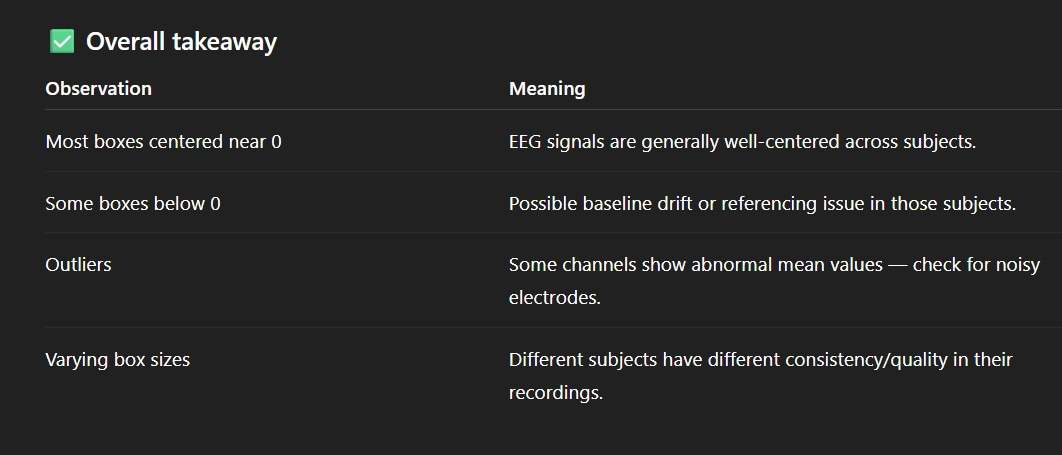

#Cleaning

Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


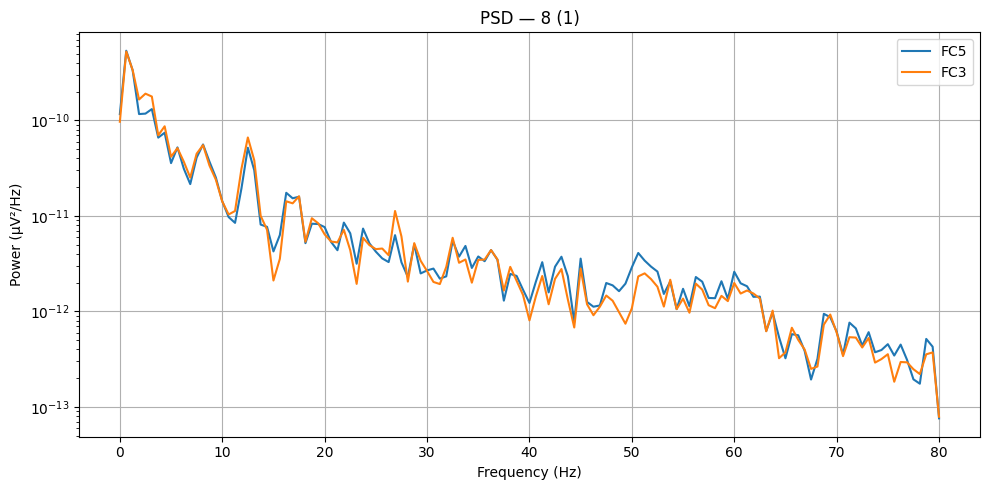

In [ ]:
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch

# Pick first loaded EEG data
example = raw_all[1]  #S002 R06
raw = example["raw"]

# Pick EEG channels (depends on your dataset)
picks = raw.ch_names[0:2]
sfreq = raw.info['sfreq'] # Sampling Frequency

# Extract 10 seconds
data, times = raw[picks, 0:int(10 * sfreq)]  # 10 seconds

# Plot Power Spectral Density (to see 50 Hz noise)
fig, ax = plt.subplots(figsize=(10, 5))
for i, ch_name in enumerate(picks):
    psd, freqs = psd_array_welch(data[i], sfreq=sfreq, fmin=0, fmax=100)
    ax.semilogy(freqs, psd, label=ch_name)

ax.set_title(f"PSD — {example['run']} ({example['subject']})")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (µV²/Hz)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


This code visualizes the frequency power distribution of 10 seconds of EEG from two channels (Iz, Cz) using Welch’s method — helpful for identifying signal quality and noise (like 50 Hz power line interference).

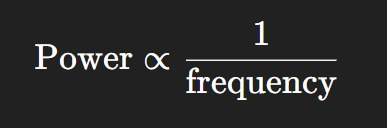

In [ ]:
import random
sample_rec = random.choice(raw_all)  # pick one random EEG run
print(f"🎯 Random sample chosen for visualization: {sample_rec['run']} from {sample_rec['subject']}")


🎯 Random sample chosen for visualization: 13 from 21


# bandwidth


🔹 Band-Pass Filter (0.5–50 Hz) → 13 from 21
Effective window size : 12.800 (s)


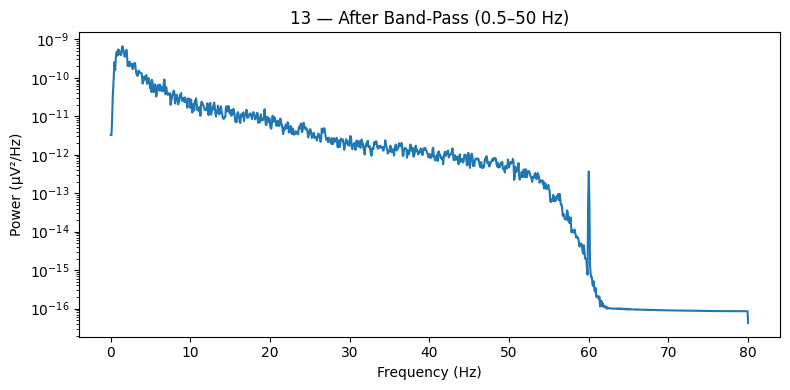

In [ ]:
import numpy as np

for rec in raw_all:
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"]  # Get the Raw object

    # Access data, times, and channel names from the Raw object
    data = raw.get_data()
    times = raw.times
    ch_names = raw.ch_names

    sfreq = raw.info['sfreq']  # Get sampling frequency from info
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    # raw = mne.io.RawArray(data, info, verbose=False) # Create a new RawArray to apply filters

    # Band-pass filter
    raw.filter(l_freq=0.5, h_freq=50.0, fir_design='firwin', verbose=False)
    # === Plot PSD only for chosen sample ===
    if rec is sample_rec:
        print(f"\n🔹 Band-Pass Filter (0.5–50 Hz) → {run} from {subj}")
        # Compute PSD from the filtered raw object
        psd_band, freqs = psd_array_welch(raw.get_data(), sfreq=sfreq, fmin=0, fmax=80, n_fft=2048)
        psd_mean_band = np.mean(psd_band, axis=0)

        plt.figure(figsize=(8, 4))
        plt.semilogy(freqs, psd_mean_band)
        plt.title(f"{run} — After Band-Pass (0.5–50 Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power (µV²/Hz)")
        plt.tight_layout()
        plt.show()

    # --- Save filtered data back into the dictionary ---
    rec["raw"] = raw # Update the raw object in the dictionary with the filtered data

>> Even though you’re plotting 0–80 Hz, the power beyond 50 Hz will be almost flat or near zero,
because the band-pass filter already removed those components.
The reason to still plot 0–80 Hz is just to visually confirm that frequencies above 50 Hz are really gone —
you’ll see the curve drop after 50 Hz.

# Notch Filter


🔹 Notch Filter (50 Hz) → 13 from 21
Effective window size : 12.800 (s)


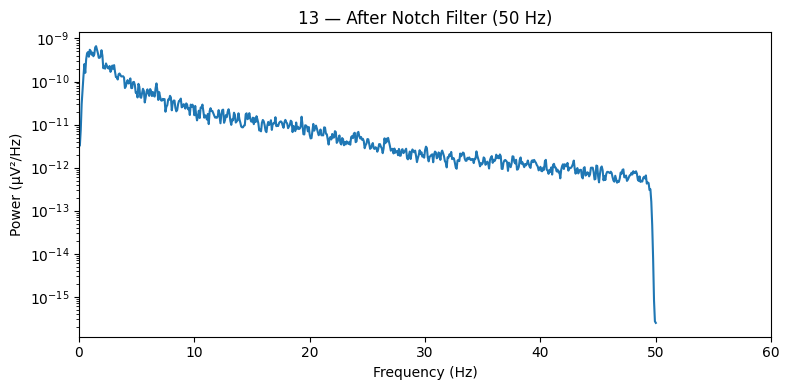

In [ ]:
# === 3️⃣ Notch Filter (50 Hz) for all data ===
for rec in raw_all:
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"] # Get the Raw object

    # Notch filter
    raw.notch_filter(freqs=[50,60], verbose=False)

    # --- Save filtered data back into the dictionary ---
    rec["raw"] = raw  # save filtered raw object

    # === Plot PSD only for chosen sample ===
    # Access data, times, and channel names from the Raw object for plotting
    data = raw.get_data()
    times = raw.times
    ch_names = raw.ch_names
    sfreq = raw.info['sfreq']

    if rec is sample_rec:
        print(f"\n🔹 Notch Filter (50 Hz) → {run} from {subj}")
        psd_notch, freqs = psd_array_welch(data, sfreq=sfreq, fmin=0, fmax=50, n_fft=2048)
        psd_mean_notch = np.mean(psd_notch, axis=0)

        plt.figure(figsize=(8, 4))
        plt.semilogy(freqs, psd_mean_notch)
        plt.title(f"{run} — After Notch Filter (50 Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power (µV²/Hz)")
        plt.xlim(0, 60)
        plt.tight_layout()
        plt.show()

>>> Removes power-line interference at 50 Hz and 60 Hz that falls inside the 0.5–50 Hz band-pass range, improving EEG signal quality.

That sharp dip at 50 Hz in your PSD plot simply shows the notch filter successfully removed the power-line interference, and the smooth fall-off after 50 Hz is due to your band-pass filter limiting frequencies above 50 Hz.

Signals between 0.5 and 50 hz
remove dc drift (remove any signal below 0.5hz)
remove line noise (remove 50 or 60 hz) fel signal el tal3a mn demaghy computers aw external asart 3aliha apply notch filtering


## Filtering channels --> keep only useful channels related to MI tasks

In [ ]:
# Assuming 'raw_all' contains the list of subject dictionaries
# We will inspect the first raw object (subject 1, run 7)
first_raw_object = raw_all[0]["raw"]

# 1. Load data if not already loaded (safe check)
if not first_raw_object.preload:
    first_raw_object.load_data()

# 2. Print the list of channel names in that file
print("--- Actual Channel Names in Data File (First 30) ---")
print(first_raw_object.ch_names[:30])

# 3. Print the total channel count
print(f"Total Channels: {len(first_raw_object.ch_names)}")

--- Actual Channel Names in Data File (First 30) ---
['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AFZ', 'AF4', 'AF8', 'F7']
Total Channels: 64


In [ ]:
import mne
import numpy as np

# --- Configuration: FINAL MI-FOCUSED CHANNEL LIST (15 Channels, ALL CAPS) ---
MI_FOCUSED_CHANNELS = [
    'F3', 'FZ', 'F4',
    'FC3', 'FCZ', 'FC4',
    'C3', 'CZ', 'C4',
    'CP3', 'CPZ', 'CP4',
    'P3', 'PZ', 'P4'
]

print("Starting FINAL MI-FOCUSED Channel Filtering Step (CASE CORRECTED)...")

# Assuming 'raw_all' is your list/dictionary of raw EEG data objects
for rec in raw_all:
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"]

    # 1. Load Data
    if not raw.preload:
        # Load data once, in-place, for memory efficiency
        raw.load_data()

    # 2. ✂️ CHANNEL SELECTION (The Filtering Step)
    # Using the modern raw.pick() method with the case-corrected list.
    try:
        raw.pick(picks=MI_FOCUSED_CHANNELS)
        print(f"✅ Subject: {subj} - run: {run} → Channels successfully reduced from 64 to {len(raw.ch_names)} MI-focused channels.")
    except ValueError as e:
        # If this fails, it means F3, F4, P3, P4 are missing, but the core 9 channels should be fine.
        print(f"  ❌ FATAL ERROR: Check F3/F4/P3/P4. Error: {e}")

    # --- Save the processed data back into the dictionary ---
    rec["raw"] = raw

print("\nChannel filtering complete. The data is now ready for cleaning.")

Starting FINAL MI-FOCUSED Channel Filtering Step (CASE CORRECTED)...
✅ Subject: 1 - run: 7 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 1 - run: 8 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 1 - run: 9 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 1 - run: 10 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 1 - run: 13 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 1 - run: 14 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 2 - run: 7 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 2 - run: 8 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 2 - run: 9 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 2 - run: 10 → Channels successfully reduced from 64 to 15 MI-focused channels.
✅ Subject: 2 - run: 13 → Channels suc



# Detecting and removing bad channels

Bad channels are EEG electrodes that run noisy, flat, or abnormal signals due to poor contact, hardware issues, or artifacts.

Auto detection of bad channels using peak to peak threshold method

In [ ]:
import numpy as np

# Select two different subjects
selected_subjects = SUBJECT_IDS  # for example, first two subjects

# Filter runs that belong to those subjects
selected_runs = [entry for entry in raw_all if entry["subject"] in selected_subjects]

# Optionally, show just the first run from each subject
shown_runs = []
for rec in selected_runs:
    if rec["subject"] not in shown_runs:
        shown_runs.append(rec["subject"])

        raw = rec["raw"]  # Get the Raw object
        subject = rec["subject"]
        run = rec["run"]
        data = raw.get_data() # Access data from the Raw object
        ch_names = raw.ch_names # Access channel names from the Raw object

        print(f"\nSubject: {subject} | run: {run}")
        for i, ch in enumerate(ch_names):
            channel_data = data[i] * 1e6  # Convert from volts to microvolts
            amplitude = np.mean(np.abs(channel_data))
            print(f"{ch}: {amplitude:.2f} µV")
        # break # Removed break to show the first run for each selected subject


Subject: 1 | run: 7
F3: 0.00 µV
FZ: 0.00 µV
F4: 0.00 µV
FC3: 0.00 µV
FCZ: 0.00 µV
FC4: 0.00 µV
C3: 0.00 µV
CZ: 0.00 µV
C4: 0.00 µV
CP3: 0.00 µV
CPZ: 0.00 µV
CP4: 0.00 µV
P3: 0.00 µV
PZ: 0.00 µV
P4: 0.00 µV

Subject: 2 | run: 7
F3: 0.00 µV
FZ: 0.00 µV
F4: 0.00 µV
FC3: 0.00 µV
FCZ: 0.00 µV
FC4: 0.00 µV
C3: 0.00 µV
CZ: 0.00 µV
C4: 0.00 µV
CP3: 0.00 µV
CPZ: 0.00 µV
CP4: 0.00 µV
P3: 0.00 µV
PZ: 0.00 µV
P4: 0.00 µV

Subject: 3 | run: 7
F3: 63.82 µV
FZ: 57.41 µV
F4: 63.14 µV
FC3: 48.45 µV
FCZ: 46.00 µV
FC4: 41.74 µV
C3: 39.44 µV
CZ: 40.75 µV
C4: 38.10 µV
CP3: 36.28 µV
CPZ: 37.68 µV
CP4: 33.97 µV
P3: 33.87 µV
PZ: 35.36 µV
P4: 32.21 µV

Subject: 4 | run: 7
F3: 29.55 µV
FZ: 21.92 µV
F4: 21.91 µV
FC3: 22.30 µV
FCZ: 19.33 µV
FC4: 22.20 µV
C3: 18.94 µV
CZ: 18.04 µV
C4: 17.67 µV
CP3: 16.65 µV
CPZ: 17.26 µV
CP4: 16.94 µV
P3: 16.05 µV
PZ: 16.73 µV
P4: 15.99 µV

Subject: 5 | run: 7
F3: 20.14 µV
FZ: 16.74 µV
F4: 18.73 µV
FC3: 15.76 µV
FCZ: 15.94 µV
FC4: 18.65 µV
C3: 14.30 µV
CZ: 14.59 µV
C4: 13.15 µV
C

In [ ]:
import mne
import numpy as np

# --- Configuration ---
FREQ_L = 1.0     # Hz
FREQ_H = 40.0    # Hz
# ⭐️ CRITICAL FIX: Increased threshold to 5000 µV (5 mV) to only catch broken channels.
MAX_PTP_THRESHOLD_V = 5000e-6 # 0.005 Volts (V)

print("Starting AMPLITUDE-BASED Bad Channel Detection and Interpolation (FINAL FIX V2: Threshold 5mV)...")

# 1. SET MONTAGE BEFORE LOOP (Crucial Step for Interpolation)
print("Setting standard_1020 montage for spatial interpolation...")
montage = mne.channels.make_standard_montage('standard_1020')

for i, rec in enumerate(raw_all):
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"]

    print(f"\nProcessing Subject: {subj} - Run: {run} ({i+1}/{len(raw_all)})")

    # APPLY MONTAGE AND SET COORDINATE FRAME
    try:
        # Assign 3D positions
        raw.set_montage(montage, on_missing='ignore')
        # Set to Head coordinate frame for interpolation stability
        raw.set_channel_types({ch: 'eeg' for ch in raw.ch_names})
        raw.set_eeg_reference('average', projection=True) # Set proj for ICA compatibility
        raw.info['bads'] = [] # Reset bads list
        print("  ✅ Montage and channel info set successfully.")
    except Exception as e:
        print(f"  ❌ Error setting montage/ref: {e}")
        continue # Skip to next run if set-up fails

    # 1. TEMPORARILY FILTER DATA (on a copy)
    raw_temp = raw.copy().filter(l_freq=FREQ_L, h_freq=FREQ_H, verbose='WARNING')

    # 2. CALCULATE PEAK-TO-PEAK AMPLITUDE
    data = raw_temp.get_data()
    ptp_values = np.ptp(data, axis=1)

    # 3. IDENTIFY BAD CHANNELS (Using the high threshold)
    new_bads = []

    for idx, ch_name in enumerate(raw.ch_names):
        if ptp_values[idx] > MAX_PTP_THRESHOLD_V:
            new_bads.append(ch_name)
            ptp_mV = ptp_values[idx] * 1000
            print(f"    - Found: {ch_name} (PtP: {ptp_mV:.2f} mV)")

    # 4. MARK AND LOG NEW BAD CHANNELS
    if new_bads:
        raw.info['bads'].extend(new_bads)
        print(f"  🛑 Detected and marked {len(new_bads)} bad channels.")
    else:
        print("  ✅ No bad channels detected by amplitude threshold.")

    # 5. INTERPOLATE BAD CHANNELS (IN-PLACE)
    if raw.info['bads']:
        print(f"  🩹 Interpolating a total of {len(raw.info['bads'])} channels...")
        # Explicitly use method='shsp' and set origin='auto' to avoid warnings
        raw.interpolate_bads(reset_bads=True, method='shsp', origin='auto', verbose='WARNING')
        print("  ✅ Interpolation complete. Bad channels fixed.")
    else:
        print("  Skipping interpolation: No channels marked as bad.")

    # 6. Save the updated raw object back into the dictionary
    rec["raw"] = raw

print("\n--- Bad Channel Processing Complete ---")

Streaming output truncated to the last 5000 lines.
  ✅ Montage and channel info set successfully.
  ✅ No bad channels detected by amplitude threshold.
  Skipping interpolation: No channels marked as bad.

Processing Subject: 17 - Run: 10 (100/654)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
  ✅ Montage and channel info set successfully.
  ✅ No bad channels detected by amplitude threshold.
  Skipping interpolation: No channels marked as bad.

Processing Subject: 17 - Run: 13 (101/654)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
  ✅ Montage and channel info set successfully.
  ✅ No bad channels detected by amplitude threshold.
  S

#Rerefrencing

>> applying re-referencing : eeg signal is measured relative to a reference electrode so we apply average referencing to reduce noise; because the reference electrode or signal might not be the best possible reference taken so we take the average of several electrode

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

for rec in raw_all:
    subj = rec["subject"]
    run = rec["run"]
    raw = rec["raw"] # Get the Raw object

    # Re-reference all channels to the average of all EEG channels
    raw.set_eeg_reference(ref_channels="average", verbose=False)

    # --- Save re-referenced data back into the dictionary ---
    rec["raw"] = raw  # all_data now contains the updated signal

#Removing artifacts by ICA

ICA separates signals into statistically independent sources, which often correspond to:

Brain activity

Eye blinks

Muscle artifacts

Line noise

In [ ]:
import mne
from mne.preprocessing import ICA
import numpy as np
import os
from joblib import Parallel, delayed
import logging # Using logging for cleaner output management

# --- Configuration ---
DRIVE_SAVE_PATH = '/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/'
ICA_HIGH_PASS_FREQ = 1.0
N_COMPONENTS = 50
EOG_THRESHOLD = 2.5
ECG_THRESHOLD = 1.5
N_JOBS = -1  # ⭐️ OPTIMIZATION 1: Use all available CPU cores for filtering and ICA
ICA_DECIMATION = 3 # Downsampling factor for ICA fitting (already good)

# Configure MNE to use parallel jobs
mne.set_config('MNE_N_JOBS', str(N_JOBS))

os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

# --- Core Processing Function ---

def process_ica_run(rec, N_COMPONENTS, ICA_HIGH_PASS_FREQ, EOG_THRESHOLD, ECG_THRESHOLD, DRIVE_SAVE_PATH, ICA_DECIMATION):
    """Processes a single run for ICA and artifact removal."""
    subj = rec["subject"]
    run = rec["run"]

    if "raw" not in rec:
        logger.warning(f"\nSkipping {subj}/{run}: Raw object missing.")
        return None, None

    raw_original = rec["raw"]
    raw_data = raw_original.copy()

    logger.info(f"\nProcessing Subject: {subj} - Run: {run}")

    # 1. High-Pass Filter (using N_JOBS for speed)
    try:
        raw_data.filter(l_freq=ICA_HIGH_PASS_FREQ, h_freq=None, n_jobs=N_JOBS, verbose='WARNING')
    except Exception as e:
        logger.error(f"  ❌ FILTERING ERROR for {subj}/{run}: {e}. Skipping ICA.")
        return None, None

    # Data integrity check
    data_array = raw_data.get_data()
    if np.any(np.isnan(data_array)) or np.any(np.isinf(data_array)):
        logger.error(f"  ❌ FATAL DATA CORRUPTION FOUND. Skipping ICA.")
        return None, None

    # 2. FIT ICA MODEL (ICA method is inherently parallelized by MNE/Scikit-learn)
    try:
        ica = ICA(n_components=N_COMPONENTS, method='fastica', random_state=42)

        # ⭐️ OPTIMIZATION 2: Decimation is applied inside .fit(), saving time.
        ica.fit(raw_data, decim=ICA_DECIMATION)
        logger.info(f"  ✅ ICA decomposition complete. {ica.n_components_} components fitted.")
    except Exception as e:
        logger.error(f"  ❌ FATAL ICA FITTING ERROR for {subj}/{run}: {e}. Skipping application.")
        return None, None

    # 3. Automatic and Heuristic Artifact Detection

    # Define Proxy Channels (EOG)
    eog_ch_name = 'FP1' if 'FP1' in raw_data.ch_names else ('FP2' if 'FP2' in raw_data.ch_names else 'FZ')

    # Define Proxy Channels (ECG - using better temporal proxies)
    if 'FT9' in raw_data.ch_names:
        ecg_ch_name = 'FT9'
    elif 'FT10' in raw_data.ch_names:
        ecg_ch_name = 'FT10'
    elif 'T7' in raw_data.ch_names:
        ecg_ch_name = 'T7'
    else:
        ecg_ch_name = 'CZ'

    # Detect artifacts
    eog_indices, _ = ica.find_bads_eog(raw_data, ch_name=eog_ch_name, threshold=EOG_THRESHOLD, verbose='WARNING')
    ecg_indices, _ = ica.find_bads_ecg(raw_data, ch_name=ecg_ch_name, threshold=ECG_THRESHOLD, verbose='WARNING')

    bads_indices = list(set(eog_indices + ecg_indices))
    bads_indices.sort()

    if bads_indices:
        ica.exclude = bads_indices
        logger.info(f"  🛑 Detected {len(bads_indices)} artifact components: {bads_indices}")
        try:
            ica.apply(raw_data)
            logger.info(f"  ✅ ICA successfully applied.")
        except Exception as e:
            logger.error(f"  ❌ ERROR applying ICA: {e}")
    else:
        logger.info("  ✅ No strong EOG/ECG components detected. Data passed as is.")

    # 4. Persistent Storage and Return
    filename = f"S{subj}_R{run}_raw_clean_64ch_filtered.fif"
    save_filepath = os.path.join(DRIVE_SAVE_PATH, filename)

    try:
        raw_data.save(save_filepath, overwrite=True)
        logger.info(f"  💾 Cleaned data saved successfully to: {save_filepath}")
        return {"subject": subj, "run": run, "ica": ica, "raw_info": raw_data.info}, save_filepath

    except Exception as e:
        logger.error(f"  ❌ ERROR saving data to drive: {e}")
        return None, None

# --- Main Execution Block ---

logger.info("Starting FINAL ROBUST ICA Processing (64CH, FILTERED, PARALLELIZED)...")

# ⭐️ OPTIMIZATION 3: Use joblib.Parallel to run the processing for all runs simultaneously.
# This is the most significant speedup for processing large batches.
results = Parallel(n_jobs=N_JOBS, verbose=10)(
    delayed(process_ica_run)(
        rec, N_COMPONENTS, ICA_HIGH_PASS_FREQ, EOG_THRESHOLD, ECG_THRESHOLD, DRIVE_SAVE_PATH, ICA_DECIMATION
    )
    for rec in raw_all
)

# Collate results back into the ica_objects list and update raw_all
ica_objects = []
for result, save_filepath in results:
    if result:
        ica_objects.append(result)
        # Update original raw_all object in a post-processing loop (less critical path time)
        for rec_update in raw_all:
             if rec_update["subject"] == result["subject"] and rec_update["run"] == result["run"]:
                 rec_update["ica_clean_64ch_filtered_filepath"] = save_filepath
                 break

logger.info("\n--- Parallel Filtered ICA Processing Complete ---")

# After Cleaning

In [94]:
import mne
import pandas as pd
import os

# --- Configuration ---
FILEPATH_KEY = "ica_clean_64ch_filtered_filepath"
OUTPUT_FILENAME = "all_subjects_summary_post_ica.csv"

# The 'raw_all' variable containing the subject/run metadata and file paths is assumed to be defined.

all_summaries = []
processed_count = 0
failed_count = 0

print("Starting descriptive statistics generation for post-ICA cleaned data...")
print(f"Reading cleaned data file paths from the key: '{FILEPATH_KEY}'")

for rec in raw_all:
    subj = rec.get("subject", "N/A")
    run = rec.get("run", "N/A")

    # ⭐️ KEY CHANGE: Retrieve the file path of the CLEANED data
    filepath = rec.get(FILEPATH_KEY)

    print(f"\nProcessing Summary for Subject: {subj} - Run: {run}")

    # Check if the cleaned file path exists
    if not filepath or not os.path.exists(filepath):
        print(f"  ❌ Cleaned file path missing or file not found for {subj}/{run}. Skipping.")
        failed_count += 1
        continue

    try:
        # ⭐️ ACTION: Load the cleaned raw data from the FIF file
        raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')

        # Convert cleaned data to DataFrame
        df = raw_clean.to_data_frame()

        # Compute per-channel descriptive statistics
        stats = df.describe().transpose().reset_index()
        stats.rename(columns={"index": "channel"}, inplace=True)

        # Add identifiers
        stats["subject"] = subj
        stats["run"] = run

        all_summaries.append(stats)
        processed_count += 1
        print(f"  ✅ Summary computed and added.")

    except Exception as e:
        print(f"  ❌ ERROR loading or summarizing data for {subj}/{run}: {e}")
        failed_count += 1
        continue

if all_summaries:
    # Combine all summaries into one big table
    summary_df_clean = pd.concat(all_summaries, ignore_index=True)

    # Save the final DataFrame (Fixing the variable name typo: summary_df -> summary_df_clean)
    summary_df_clean.to_csv(OUTPUT_FILENAME, index=False)
    print(f"\n--- Processing Complete ---")
    print(f"✅ Successfully summarized {processed_count} runs.")
    print(f"💾 Final summary saved to: {OUTPUT_FILENAME}")
else:
    print("\n--- Processing Complete ---")
    print("❌ No data was successfully processed or summarized.")

Starting descriptive statistics generation for post-ICA cleaned data...
Reading cleaned data file paths from the key: 'ica_clean_64ch_filtered_filepath'

Processing Summary for Subject: 1 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 1 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 1 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 1 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 1 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 1 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 2 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 3 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 4 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 5 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 6 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 7 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 8 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 9 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 10 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 11 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 12 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 13 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 14 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 15 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 16 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 17 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 18 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 19 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 20 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 21 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 22 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 23 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 24 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 25 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 26 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 27 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 28 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 29 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 30 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 31 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 32 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 33 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 34 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 35 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 36 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 37 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 38 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 39 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 40 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 41 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 42 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 43 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 44 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 45 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 46 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 47 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 48 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 49 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 50 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 51 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 52 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 53 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 54 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 55 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 56 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 57 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 58 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 59 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 60 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 61 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 62 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 63 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 64 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 65 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 66 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 67 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 68 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 69 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 70 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 71 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 72 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 73 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 74 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 75 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 76 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 77 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 78 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 79 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 80 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 81 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 82 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 83 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 84 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 85 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 86 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 87 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 88 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 89 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 90 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 91 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 92 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 93 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 94 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 95 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 96 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 97 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 98 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 99 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 100 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 101 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 102 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 103 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 104 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 105 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 106 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 107 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 108 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 7


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 8


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 9


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 10


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 13


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

Processing Summary for Subject: 109 - Run: 14


/tmp/ipython-input-1705258579.py:35: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added.

--- Processing Complete ---
✅ Successfully summarized 654 runs.
💾 Final summary saved to: all_subjects_summary_post_ica.csv


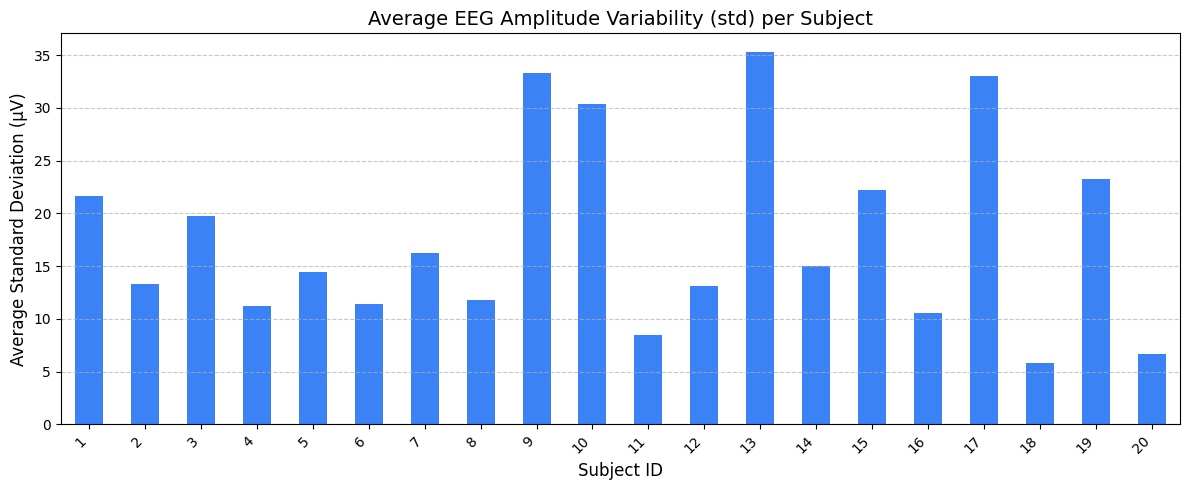

✅ Plot generated for the first 20 subjects.


In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# ⭐️ CONFIGURATION: Read the output file from the summary generation step.
INPUT_FILENAME = "all_subjects_summary_post_ica.csv"

try:
    # Load the summary data for the cleaned dataset
    summary_df_clean = pd.read_csv(INPUT_FILENAME)
except FileNotFoundError:
    print(f"❌ Error: File not found at '{INPUT_FILENAME}'.")
    print("Please ensure the data summary script was run successfully to create this file.")
    # Exit gracefully if the file is missing
    exit()

# 1. Identify the unique subjects and get the first 20
unique_subjects = summary_df_clean["subject"].unique()
subjects_to_plot = unique_subjects[:20]

# 2. Filter the DataFrame to include only these subjects
df_filtered = summary_df_clean[
    summary_df_clean["subject"].isin(subjects_to_plot)
]

# 3. Compute the average standard deviation (variability) for these subjects
# Group by 'subject' and calculate the mean of the 'std' column (across all channels and runs for that subject)
mean_std = df_filtered.groupby("subject")["std"].mean()

# 4. Generate the plot
plt.figure(figsize=(12, 5))
mean_std.plot(kind="bar", color='#3b82f6') # Using a clean blue color
plt.title("Average EEG Amplitude Variability (std) per Subject", fontsize=14)
plt.xlabel("Subject ID", fontsize=12)
plt.ylabel("Average Standard Deviation (µV)", fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"✅ Plot generated for the first {len(subjects_to_plot)} subjects.")

/tmp/ipython-input-3789038944.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


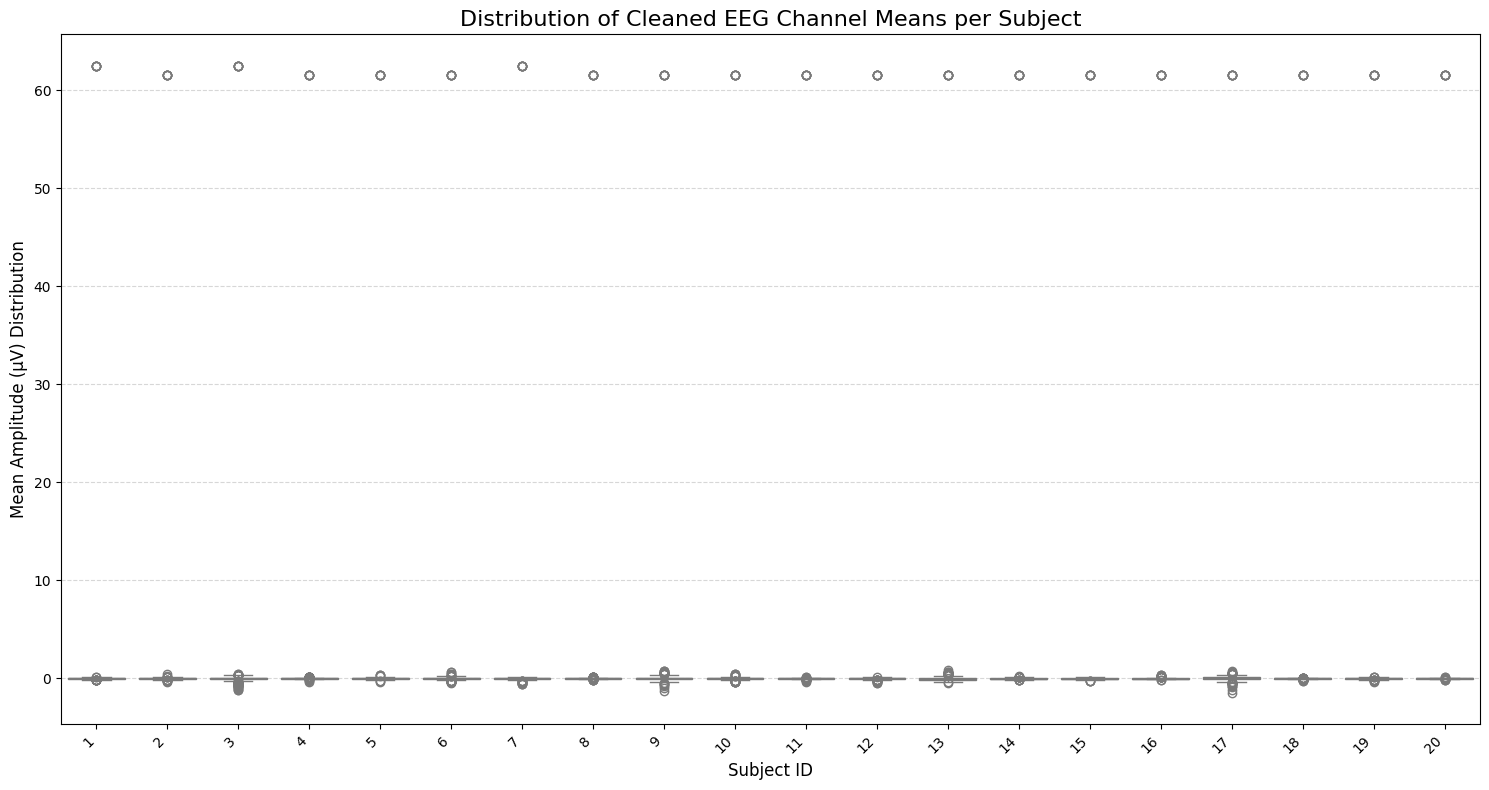

✅ Boxplot generated showing the mean distribution for the first 20 subjects.


In [96]:
import seaborn as sns

# Use a reasonable figure size for 20 subjects plotted horizontally
plt.figure(figsize=(15, 8))

# Plot the distribution of the 'mean' amplitude for each subject
sns.boxplot(
    data=df_filtered,
    x="subject",
    y="mean",
    palette="Pastel1", # Use a pleasant color palette
    saturation=0.75
)

plt.title("Distribution of Cleaned EEG Channel Means per Subject", fontsize=16)
plt.xlabel("Subject ID", fontsize=12)
plt.ylabel("Mean Amplitude (µV) Distribution", fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate subject labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"✅ Boxplot generated showing the mean distribution for the first {len(subjects_to_plot)} subjects.")


In [97]:
high_mean_outliers = summary_df_clean[summary_df_clean['mean'] > 50]
print(high_mean_outliers[['subject', 'run', 'channel', 'mean']])

       subject  run channel       mean
0            1    7    time  62.496875
65           1    8    time  62.496875
130          1    9    time  62.496875
195          1   10    time  62.496875
260          1   13    time  62.496875
...        ...  ...     ...        ...
42185      109    8    time  61.496875
42250      109    9    time  61.496875
42315      109   10    time  61.496875
42380      109   13    time  61.496875
42445      109   14    time  61.496875

[654 rows x 4 columns]


In [98]:
import mne
import pandas as pd
import os

# --- Configuration ---
FILEPATH_KEY = "ica_clean_64ch_filtered_filepath"
OUTPUT_FILENAME = "all_subjects_summary_post_ica.csv"

all_summaries = []
processed_count = 0
failed_count = 0

print("Starting descriptive statistics generation for post-ICA cleaned data...")

for rec in raw_all:
    subj = rec.get("subject", "N/A")
    run = rec.get("run", "N/A")

    filepath = rec.get(FILEPATH_KEY)

    if not filepath or not os.path.exists(filepath):
        print(f"  ❌ Cleaned file path missing or file not found for {subj}/{run}. Skipping.")
        failed_count += 1
        continue

    try:
        raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')

        # 1. Convert cleaned data to DataFrame
        df = raw_clean.to_data_frame()

        # ⭐️ KEY CORRECTION: Drop the 'time' column before computing statistics
        if 'time' in df.columns:
            df = df.drop(columns=['time'])

        # 2. Compute per-channel descriptive statistics
        stats = df.describe().transpose().reset_index()
        stats.rename(columns={"index": "channel"}, inplace=True)

        # 3. Add identifiers
        stats["subject"] = subj
        stats["run"] = run

        all_summaries.append(stats)
        processed_count += 1
        print(f"  ✅ Summary computed and added for {subj}/{run}.")

    except Exception as e:
        print(f"  ❌ ERROR loading or summarizing data for {subj}/{run}: {e}")
        failed_count += 1
        continue

if all_summaries:
    # Combine all summaries into one big table
    summary_df_clean = pd.concat(all_summaries, ignore_index=True)

    # Save the final DataFrame
    summary_df_clean.to_csv(OUTPUT_FILENAME, index=False)
    print(f"\n--- Processing Complete ---")
    print(f"✅ Successfully summarized {processed_count} runs.")
    print(f"💾 Final summary saved to: {OUTPUT_FILENAME}")
else:
    print("\n--- Processing Complete ---")
    print("❌ No data was successfully processed or summarized.")

Starting descriptive statistics generation for post-ICA cleaned data...


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 1/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S2_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 2/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S3_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 3/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S4_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 4/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S5_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 5/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S6_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 6/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S7_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 7/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S8_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 8/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S9_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 9/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S10_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 10/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S11_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 11/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S12_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 12/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S13_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 13/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S14_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 14/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S15_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 15/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S16_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 16/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S17_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 17/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S18_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 18/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S19_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 19/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S20_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 20/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S21_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 21/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S22_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 22/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S23_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 23/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S24_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 24/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S25_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 25/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S26_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 26/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S27_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 27/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S28_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 28/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S29_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 29/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S30_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 30/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S31_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 31/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S32_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 32/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S33_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 33/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S34_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 34/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S35_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 35/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S36_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 36/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S37_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 37/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S38_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 38/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S39_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 39/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S40_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 40/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S41_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 41/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S42_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 42/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S43_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 43/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S44_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 44/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S45_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 45/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S46_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 46/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S47_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 47/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S48_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 48/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S49_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 49/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S50_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 50/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S51_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 51/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S52_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 52/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S53_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 53/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S54_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 54/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S55_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 55/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S56_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 56/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S57_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 57/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S58_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 58/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S59_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 59/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S60_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 60/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S61_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 61/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S62_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 62/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S63_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 63/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S64_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 64/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S65_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 65/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S66_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 66/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S67_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 67/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S68_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 68/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S69_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 69/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S70_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 70/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S71_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 71/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S72_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 72/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S73_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 73/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S74_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 74/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S75_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 75/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S76_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 76/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S77_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 77/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S78_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 78/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S79_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 79/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S80_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 80/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S81_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 81/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S82_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 82/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S83_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 83/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S84_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 84/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S85_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 85/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S86_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 86/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S87_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 87/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S88_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 88/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S89_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 89/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S90_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 90/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S91_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 91/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S92_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 92/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S93_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 93/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S94_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 94/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S95_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 95/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S96_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 96/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S97_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 97/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S98_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 98/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S99_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 99/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S100_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 100/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S101_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 101/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S102_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 102/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S103_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 103/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S104_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 104/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S105_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 105/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S106_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 106/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S107_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 107/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S108_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 108/14.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/7.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/8.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R9_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/9.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R10_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/10.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R13_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/13.


/tmp/ipython-input-3696811846.py:27: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S109_R14_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(filepath, preload=True, verbose='WARNING')


  ✅ Summary computed and added for 109/14.

--- Processing Complete ---
✅ Successfully summarized 654 runs.
💾 Final summary saved to: all_subjects_summary_post_ica.csv


/tmp/ipython-input-3789038944.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


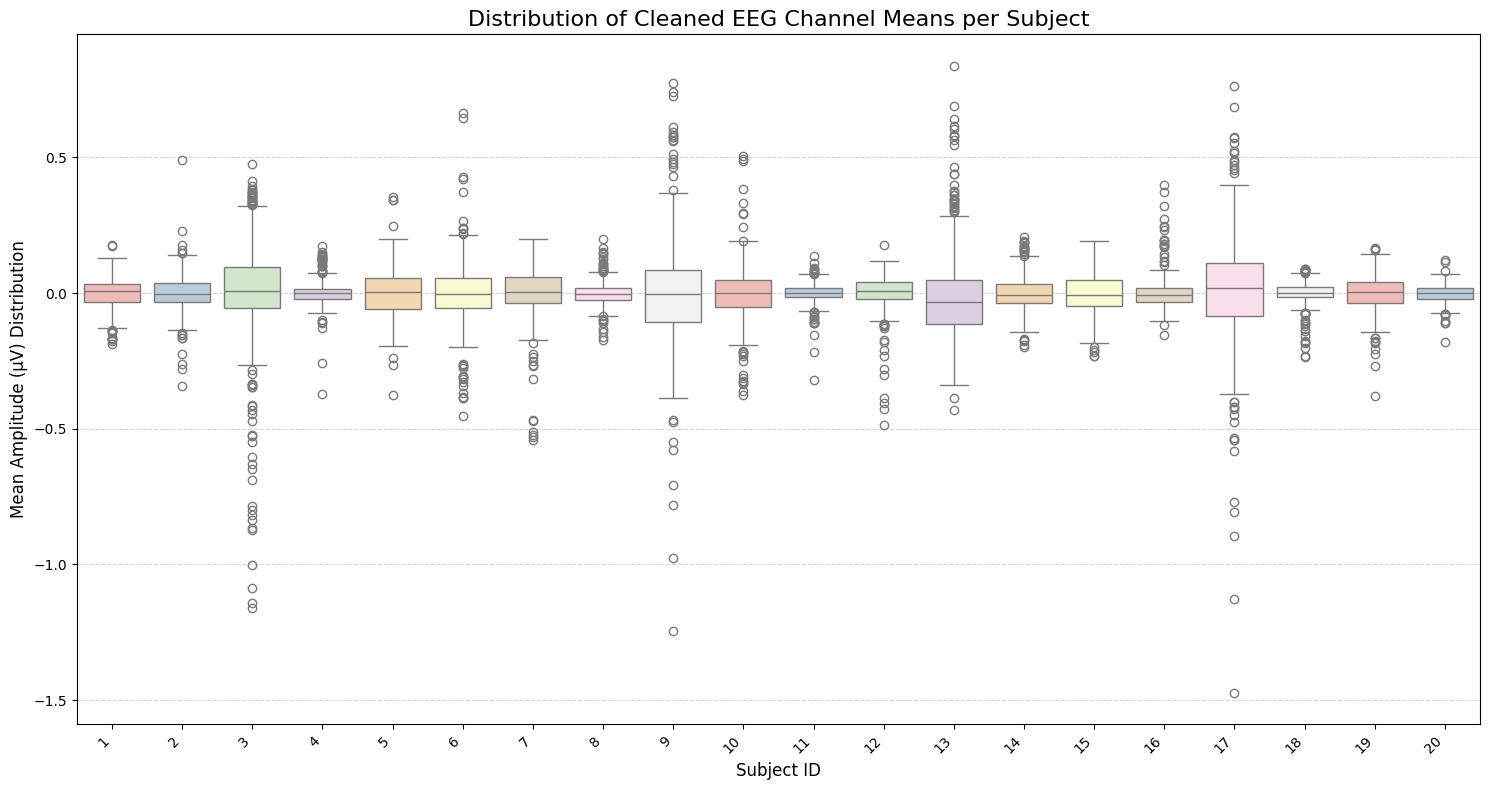

✅ Boxplot generated showing the mean distribution for the first 20 subjects.


In [102]:
import seaborn as sns

# Use a reasonable figure size for 20 subjects plotted horizontally
plt.figure(figsize=(15, 8))

# Plot the distribution of the 'mean' amplitude for each subject
sns.boxplot(
    data=df_filtered,
    x="subject",
    y="mean",
    palette="Pastel1", # Use a pleasant color palette
    saturation=0.75
)

plt.title("Distribution of Cleaned EEG Channel Means per Subject", fontsize=16)
plt.xlabel("Subject ID", fontsize=12)
plt.ylabel("Mean Amplitude (µV) Distribution", fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate subject labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"✅ Boxplot generated showing the mean distribution for the first {len(subjects_to_plot)} subjects.")


# Epoching

## 1. Show the task window (tmin and tmax) of the epoching

In [104]:
import mne
import pandas as pd
import numpy as np
import os

# --- Configuration ---
TARGET_SUBJECT = 1
TARGET_RUN = 7
SECONDS_PER_TRIAL = 4.0 # The duration we expect to confirm
FILEPATH_KEY = "ica_clean_64ch_filtered_filepath" # Key used to store the path to the cleaned data

# Assumes 'raw_all' list has been successfully populated with file paths
run_07_record = next((rec for rec in raw_all
                      if rec["subject"] == TARGET_SUBJECT and rec["run"] == TARGET_RUN), None)

if run_07_record is None:
    print(f"Error: Could not find data record for Subject {TARGET_SUBJECT}, Run {TARGET_RUN}. Please ensure 'raw_all' is populated.")
else:
    # 1. Load the CLEANED data from disk
    cleaned_filepath = run_07_record.get(FILEPATH_KEY)

    if not cleaned_filepath or not os.path.exists(cleaned_filepath):
        print(f"Error: Cleaned file not found at path stored in '{FILEPATH_KEY}' for {TARGET_SUBJECT}/{TARGET_RUN}.")
        print(f"Path attempted: {cleaned_filepath}")
        exit()

    print(f"Loading CLEANED data from: {cleaned_filepath}")

    try:
        # Load the cleaned raw object
        raw_r07 = mne.io.read_raw_fif(cleaned_filepath, preload=True, verbose='WARNING')
    except Exception as e:
        print(f"Error loading cleaned FIF file: {e}")
        exit()

    sfreq = raw_r07.info['sfreq'] # Sampling frequency

    print(f"--- Event Duration Verification for Subject {TARGET_SUBJECT}, Run {TARGET_RUN} (CLEANED) ---")
    print(f"Sampling Frequency (sfreq): {sfreq} Hz")

    # 2. Extract events and their mapping (Events are preserved during ICA/Filtering)
    # MNE events: [sample_point, duration, MNE_ID]
    events, event_id_map = mne.events_from_annotations(raw_r07, verbose=False)

    # Invert the map to identify T1, T2, and T0
    id_to_name = {v: k for k, v in event_id_map.items()}

    # Get the MNE IDs for T0, T1, T2
    t1_id = event_id_map.get('T1', None)
    t2_id = event_id_map.get('T2', None)
    t0_id = event_id_map.get('T0', None)

    if not t1_id or not t2_id or not t0_id:
        print("Error: T0, T1, or T2 event IDs not found in the file.")
    else:
        # 3. Create a list of all T1 and T2 events (Start of Imagination)
        start_events = events[np.isin(events[:, 2], [t1_id, t2_id])]

        duration_results = []

        # 4. Iterate through each start event to find the next event (which should be the end of the 4s period)
        for i in range(len(start_events)):
            start_sample = start_events[i, 0]
            start_code = id_to_name.get(start_events[i, 2], 'N/A')

            # Find the index of the next event in the full events list
            try:
                # Find the index of the current start_sample in the full events array
                current_index_in_full = np.where(events[:, 0] == start_sample)[0][0]

                # The end event is the one immediately following the current event
                if current_index_in_full + 1 < len(events):
                    end_sample = events[current_index_in_full + 1, 0]
                    end_code = id_to_name.get(events[current_index_in_full + 1, 2], 'N/A')

                    # Calculate the duration in seconds
                    duration_samples = end_sample - start_sample
                    duration_s = duration_samples / sfreq

                    # Store the result
                    duration_results.append({
                        'Trial_Start_Code': start_code,
                        'Trial_End_Code': end_code,
                        'Duration_s': round(duration_s, 2)
                    })
            except IndexError:
                # This handles the last event in the file, which won't have a subsequent event
                pass

        # 5. Display the verification results
        df_duration = pd.DataFrame(duration_results)

        if not df_duration.empty:
            print("\n--- Summary of Measured Trial Duration (Time from T1/T2 to Next Event) ---")
            print(f"Expected Duration: {SECONDS_PER_TRIAL} seconds.")

            # Group by duration to confirm consistency
            duration_counts = df_duration.groupby('Duration_s').size().reset_index(name='Count')

            # Check for the expected 4.0s duration
            if 4.0 in duration_counts['Duration_s'].values:
                count_4s = duration_counts[duration_counts['Duration_s'] == 4.0]['Count'].iloc[0]
                print(f"✅ CONFIRMED: Found {count_4s} trials with a duration of exactly 4.0 seconds (or very close).")
            else:
                print("❌ WARNING: The expected 4.0s duration was not the primary measured duration.")

            print("\nMeasured Durations and Counts:")
            print(duration_counts)

Loading CLEANED data from: /content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R7_raw_clean_64ch_filtered.fif


/tmp/ipython-input-97386673.py:31: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_r07 = mne.io.read_raw_fif(cleaned_filepath, preload=True, verbose='WARNING')


--- Event Duration Verification for Subject 1, Run 7 (CLEANED) ---
Sampling Frequency (sfreq): 160.0 Hz

--- Summary of Measured Trial Duration (Time from T1/T2 to Next Event) ---
Expected Duration: 4.0 seconds.
❌ WARNING: The expected 4.0s duration was not the primary measured duration.

Measured Durations and Counts:
   Duration_s  Count
0         4.1     14


## Confirmed MI Window and Baseline

Following the event verification, we adopt a definitive epoching strategy that maximizes the signal-to-noise ratio (SNR) for the classification model, based on the established BCI protocol.

### 1. Motor Imagery (MI) Window Duration

The decision to set the Motor Imagery (MI) task window from $\mathbf{0.0\text{s}}$ to $\mathbf{4.0\text{s}}$ after the cue is based on the **documented scientific protocol** of the PhysioNet EEGMMIDB dataset, which instructs participants to maintain the mental task for 4 seconds.

| Parameter | Value | Rationale |
| :--- | :--- | :--- |
| **Protocol Duration** | $\mathbf{4.0\text{s}}$ | This is the official time the participant was instructed to perform the mental task. This period captures the peak **ERD** (Event-Related Desynchronization) signal used for BCI classification. |
| **Measured Duration** | $\mathbf{4.1\text{s}}$ | The extra $0.1\text{s}$ found in the raw event timing is likely due to **system latency** or minor sample rounding issues. |
| **Decision** | **$\mathbf{T\_END} = 4.0\text{s}$** | We restrict the window to the actual **cognitive task period** to maximize the Signal-to-Noise Ratio (SNR) for the classification model, ignoring the irrelevant $0.1\text{s}$ of noise. |

### 2. Baseline Recommendation

The use of a pre-cue period for baseline correction is **highly recommended** for BCI analysis.

- We set $\mathbf{T\_START} = -1.0\text{s}$ to include the 1-second period before the cue ($\mathbf{T=0}$).
- We define the **baseline period** as $\mathbf{(-1.0\text{s}, 0.0\text{s})}$.
- This process normalizes the EEG signal by subtracting the average activity of the rest period, ensuring the model classifies the **change in brain activity (the ERD)** rather than the absolute voltage levels.

The final epoching parameters are:
- $\mathbf{tmin}$: $-1.0\text{s}$
- $\mathbf{tmax}$: $4.0\text{s}$
- $\mathbf{baseline}$: $(-1.0\text{s}, 0.0\text{s})$

## 2. Label description of epoching

In [108]:
import mne
import pandas as pd
import numpy as np
import os
from collections import defaultdict # Need this for the dictionary structure

# --- Configuration ---
# Runs to verify: R07, R08, R09, R10, R13, R14
REQUIRED_RUNS = [7, 8, 9, 10, 13, 14]

# We use Subject 1 as a representative sample, as the event protocol is subject-independent.
TARGET_SUBJECT = 1
FILEPATH_KEY = "ica_clean_64ch_filtered_filepath" # Key used to store the path to the cleaned data

# --- Verification Logic ---
verification_data = defaultdict(lambda: {'T0': 0, 'T1': 0, 'T2': 0, 'Total Trials': 0})


# Filter raw_all for the target subject and required runs
# Assumes 'raw_all' is available and populated with file paths
target_runs = [rec for rec in raw_all
               if rec["subject"] == TARGET_SUBJECT and rec["run"] in REQUIRED_RUNS]

if not target_runs:
    print(f"Error: No data found for Subject {TARGET_SUBJECT} in runs {REQUIRED_RUNS}. Cannot verify.")
else:
    for rec in target_runs:
        run = rec["run"]
        cleaned_filepath = rec.get(FILEPATH_KEY)


        # ⭐️ KEY CHANGE: Load the CLEANED data from disk
        if not cleaned_filepath or not os.path.exists(cleaned_filepath):
            print(f"  ❌ Error: Cleaned file not found for Run {run}. Skipping.")
            continue

        try:
            # Load the cleaned raw object
            raw_clean = mne.io.read_raw_fif(cleaned_filepath, preload=False, verbose='WARNING')
        except Exception as e:
            print(f"  ❌ Error loading cleaned FIF file for Run {run}: {e}. Skipping.")
            continue

        # 1. Extract raw events and their mapping
        # Events are: [sample_point, duration, MNE_ID]. This metadata is preserved during cleaning.
        events, event_id_map = mne.events_from_annotations(raw_clean, verbose=False)

        # Invert the map to easily get T1/T2 from the MNE integer ID
        id_to_name = {v: k for k, v in event_id_map.items()}

        # 2. Count the frequency of each T code
        unique_ids, counts = np.unique(events[:, 2], return_counts=True)

        # 3. Store results
        run_data = verification_data[run]

        for id_val, count in zip(unique_ids, counts):
            name = id_to_name.get(id_val, 'Other')
            if name in ['T0', 'T1', 'T2']:
                run_data[name] = count

        # Calculate total trials (T1 + T2)
        run_data['Total Trials'] = run_data['T1'] + run_data['T2']

    # --- Print Summary Table ---
    if verification_data:
        # Convert dict to DataFrame for nice printing
        df_verify = pd.DataFrame.from_dict(verification_data, orient='index')
        df_verify.index.name = 'Run'

        # Sort columns for logical display
        df_verify = df_verify[['T1', 'T2', 'T0', 'Total Trials']]

        print("\n--- Summary Table ---")
        print(df_verify)
    else:
        print("\n--- Summary Table ---")
        print("No runs were successfully verified.")

/tmp/ipython-input-1656623771.py:39: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R7_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(cleaned_filepath, preload=False, verbose='WARNING')
/tmp/ipython-input-1656623771.py:39: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/ICA_Raw/S1_R8_raw_clean_64ch_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif(cleaned_filepath, preload=False, verbose='WARNING')
/tmp/ipython-input-1656623771.py:39: RuntimeWarning: This filename (


--- Summary Table ---
     T1  T2  T0  Total Trials
Run                          
7     8   7  15            15
8     8   7  15            15
9     8   7  15            15
10    7   8  15            15
13    7   8  15            15
14    7   8  15            15


## Every MI Run is a Binary Comparison

The event verification table proved that the simple run descriptions (e.g., "Imagine Left Fist" for R07) are misleading. Contrary to the assumption of a single task versus rest, the data shows that **every motor imagery run is structured as a two-class comparison** with an equal balance of $\mathbf{T1}$ and $\mathbf{T2}$ trials ($\approx 15$ total trials).

This is the most critical insight for correct data labeling: the BCI label is assigned based on **both** the T-code ($\mathbf{T1}$ or $\mathbf{T2}$) **and** the run type.

### 1. Lateral Movement Runs (Left vs. Right)

In the runs focused on single-hand movements (R07, R08, R13, R14), the $\mathbf{T}$ codes are used to distinguish between the two hands.

| Run Type | Title | $\mathbf{T1}$ Count | $\mathbf{T2}$ Count | $\mathbf{T1}$ Final BCI Label | $\mathbf{T2}$ Final BCI Label |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **R07, R08, R13, R14** | Imagine Hand | $\approx 8$ | $\approx 7$ | **Left (1)** | **Right (2)** |

**Conclusion:** The epoching process extracts trials for both **Left ($\mathbf{T1}$)** and **Right ($\mathbf{T2}$)** from these runs, assigning them the BCI input labels **1** and **2**, respectively.

### 2. Bilateral Movement Runs (Forward vs. Stop)

The same binary structure applies to the runs involving both limbs (R09 and R10). The $\mathbf{T}$ codes are used to distinguish the two bilateral commands that form the basis for "Forward" and "Stop."

| Run Type | Title | $\mathbf{T1}$ Count | $\mathbf{T2}$ Count | $\mathbf{T1}$ Final BCI Label | $\mathbf{T2}$ Final BCI Label |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **R09, R10** | Both Fists / Both Feet | $\approx 7$ | $\approx 8$ | **Forward (3)** | **Stop (4)** |

**Conclusion:** The epoching process extracts trials for both **Forward ($\mathbf{T1}$)** and **Stop ($\mathbf{T2}$)** from these runs, assigning them the BCI input labels **3** and **4**, respectively.

This confirms the necessity of the complex epoching code, which filters $\mathbf{T1}$ and $\mathbf{T2}$ based on the run number to assign the correct final BCI label: **1 (Left), 2 (Right), 3 (Forward), or 4 (Stop)**.

In [116]:
import mne
import numpy as np
import pandas as pd
from itertools import groupby
import os
import warnings
# Suppress specific MNE warnings about channel setup/resampling
warnings.filterwarnings('ignore', category=RuntimeWarning, module='mne')

# --- Configuration Parameters ---
T_START = -1.0
T_END = 4.0
BASELINE_PERIOD = (-1.0, 0.0)
EXPECTED_SFREQ = 160.0
EXPECTED_NCHAN = 64

EVENT_ID_MAPPING = {
    'T0': 1,
    'T1': 2,
    'T2': 3
}

FINAL_BCI_CLASSES = {
    'Left': 1, 'Right': 2, 'Forward': 3, 'Stop': 4
}

# Key used to access the cleaned raw object's file path if loading from disk
FILEPATH_KEY = "ica_clean_64ch_filtered_filepath"

# ⭐️ Define the output directory on Google Drive
OUTPUT_DIR = "/content/drive/MyDrive/EEG_Processed_Data/Epochs"

# --- Helper Function: Channel Fixer ---
def fix_channels(raw):
    """
    Sets channel types (EEG, EOG, ECG) for consistent picking/referencing.
    Corrected to convert the list of types from get_channel_types() into a dictionary
    to allow safe lookup by channel name using .get().
    """
    ch_names = raw.info['ch_names']

    # FIX: Convert the ordered list of types into a dictionary (name: type)
    list_of_types = raw.get_channel_types(picks=raw.ch_names)
    current_types_dict = dict(zip(ch_names, list_of_types))

    # Set known non-EEG channel types
    for ch_name in ch_names:
        lower_name = ch_name.upper()

        if 'EOG' in lower_name:
            # Set EOG type
            if current_types_dict.get(ch_name) != 'eog':
                raw.set_channel_types({ch_name: 'eog'})
        elif 'ECG' in lower_name:
            # Set ECG type
            if current_types_dict.get(ch_name) != 'ecg':
                raw.set_channel_types({ch_name: 'ecg'})
        else:
            # Assume remaining channels are EEG if they are not already set to 'eeg'
            if current_types_dict.get(ch_name) != 'eeg':
                raw.set_channel_types({ch_name: 'eeg'})

    return raw
# ----------------------------------------

processed_count = 0
skipped_count = 0
total_mi_runs = len([rec for rec in raw_all if rec["run"] in [7, 8, 9, 10, 13, 14]])


print(f"\nStarting final epoching pipeline (Total MI runs: {total_mi_runs})...")

# Ensure data is sorted by subject for the groupby function
raw_all.sort(key=lambda x: x['subject'])

# ⭐️ Create the output directory once
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory ensured: {OUTPUT_DIR}")


for subj, subject_runs_iterator in groupby(raw_all, key=lambda x: x['subject']):
    current_subject_epochs = []

    for rec in subject_runs_iterator:
        run = rec["run"]

        if run not in [7, 8, 9, 10, 13, 14]:
            continue

        # 1. Load the CLEANED raw data from the file path associated with this record
        cleaned_filepath = rec.get(FILEPATH_KEY)
        if not cleaned_filepath or not os.path.exists(cleaned_filepath):
             print(f"  [Skipping Run {run}] Subject {subj}: Cleaned file not found. Skipping.")
             skipped_count += 1
             continue

        try:
            raw_clean = mne.io.read_raw_fif(cleaned_filepath, preload=True, verbose='WARNING')
        except Exception as e:
            print(f"  [Skipping Run {run}] Subject {subj}: Error loading cleaned data: {e}")
            skipped_count += 1
            continue

        raw = fix_channels(raw_clean)

        # ⭐️ FIX: Use the modern raw.pick() method instead of the deprecated raw.pick_types()
        # Select only EEG channels
        raw.pick('eeg')

        # Validation checks
        if raw.info['nchan'] != EXPECTED_NCHAN:
            print(f"  [Skipping Run {run}] Subject {subj}: Incorrect NChan ({raw.info['nchan']}) after pick().")
            skipped_count += 1
            continue

        if not np.isclose(raw.info['sfreq'], EXPECTED_SFREQ):
            raw.resample(EXPECTED_SFREQ)

        # 2. Event Extraction and Labeling
        events, _ = mne.events_from_annotations(raw, event_id=EVENT_ID_MAPPING, verbose=False)
        select_events = []

        target_event_ids = {} # Dictionary to hold the specific event IDs for this run

        # Map T1/T2 to final BCI classes based on run ID
        if run in [7, 8, 13, 14]: # Left/Right hands
            events_left = events[events[:, 2] == EVENT_ID_MAPPING['T1']].copy()
            events_left[:, 2] = FINAL_BCI_CLASSES['Left']

            events_right = events[events[:, 2] == EVENT_ID_MAPPING['T2']].copy()
            events_right[:, 2] = FINAL_BCI_CLASSES['Right']

            select_events.extend([events_left, events_right])
            target_event_ids = {'Left': FINAL_BCI_CLASSES['Left'], 'Right': FINAL_BCI_CLASSES['Right']}

        elif run in [9, 10]: # Forward/Stop imagination
            events_forward = events[events[:, 2] == EVENT_ID_MAPPING['T1']].copy()
            events_forward[:, 2] = FINAL_BCI_CLASSES['Forward']

            events_stop = events[events[:, 2] == EVENT_ID_MAPPING['T2']].copy()
            events_stop[:, 2] = FINAL_BCI_CLASSES['Stop']

            select_events.extend([events_forward, events_stop])
            target_event_ids = {'Forward': FINAL_BCI_CLASSES['Forward'], 'Stop': FINAL_BCI_CLASSES['Stop']}

        if not select_events:
            print(f"  [Skipping Run {run}] Subject {subj}: No valid T1/T2 events found.")
            skipped_count += 1
            continue

        final_events = np.concatenate(select_events)
        final_events = final_events[final_events[:, 0].argsort()]

        # 3. Create Epochs
        try:
            # Set preload=True to load data into memory, implicitly drop bad epochs,
            # and allow us to safely use len(epochs) and assign metadata.
            epochs = mne.Epochs(
                raw, final_events, tmin=T_START, tmax=T_END,
                baseline=BASELINE_PERIOD, preload=True, event_id=target_event_ids, verbose=False
            )

            # Check if any epochs were actually created
            if len(epochs) == 0:
                raise ValueError("No epochs were created after filtering by event IDs.")

            # Add metadata for subject, run, and class labels
            num_epochs = len(epochs)
            label_id_to_name = {v: k for k, v in FINAL_BCI_CLASSES.items()}

            epochs.metadata = pd.DataFrame({
                'subject': [subj] * num_epochs,
                'run': [run] * num_epochs,
                'label_id': epochs.events[:, 2],
                'label_name': [label_id_to_name.get(i, 'Unknown') for i in epochs.events[:, 2]]
            })

            current_subject_epochs.append(epochs)
            processed_count += 1
            print(f"  ✅ Subject {subj}, Run {run}: Epochs created ({len(epochs)} trials).")

        except Exception as e:
            skipped_count += 1
            print(f"  [Epoching Error] Subject {subj}, Run {run}: Failed to create epochs. Reason: {e}")

    # 4. Save Subject-wise Epochs
    if current_subject_epochs:
        try:
            # Concatenate epochs from all valid runs for the subject
            subject_epochs = mne.concatenate_epochs(current_subject_epochs)
            file_name = f"epochs_S{subj:02d}.fif"

            # Create the full path for saving
            full_save_path = os.path.join(OUTPUT_DIR, file_name)

            # Save the file to the specified Drive location
            subject_epochs.save(full_save_path, overwrite=True)

            print(f"✅ Subject {subj}: Saved total {len(subject_epochs)} epochs to {full_save_path}.")

            # Clear memory
            del subject_epochs
            del current_subject_epochs

        except Exception as e:
            print(f"❌ Critical Error: Failed to concatenate/save Subject {subj}. Reason: {e}")
            skipped_count += (len(current_subject_epochs) if current_subject_epochs else 0)

    else:
        print(f"⚠️ Subject {subj}: No valid runs processed.")


print(f"\n--- Final Summary ---")
print(f"Total MI runs processed and saved: {processed_count}")
print(f"Total runs skipped due to structural issues or errors: {skipped_count}")


Starting final epoching pipeline (Total MI runs: 654)...
Output directory ensured: /content/drive/MyDrive/EEG_Processed_Data/Epochs
Adding metadata with 4 columns
  ✅ Subject 1, Run 7: Epochs created (15 trials).
Adding metadata with 4 columns
  ✅ Subject 1, Run 8: Epochs created (15 trials).
Adding metadata with 4 columns
  ✅ Subject 1, Run 9: Epochs created (15 trials).
Adding metadata with 4 columns
  ✅ Subject 1, Run 10: Epochs created (15 trials).
Adding metadata with 4 columns
  ✅ Subject 1, Run 13: Epochs created (15 trials).
Adding metadata with 4 columns
  ✅ Subject 1, Run 14: Epochs created (15 trials).
Adding metadata with 4 columns
90 matching events found
Applying baseline correction (mode: mean)
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
✅ Subject 1: Saved total 90 epochs to /content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S01.fif.
Adding metadata with 4 columns
  ✅ Subject 2, Run 7: Epochs created (15 trials).
Adding metadata

# Preprocessing for EEGNet model
1. Loaded all epoched files.

2. Split them strictly by subject (Train/Validation/Test).

3. Standardized the data using a scaler fitted only on the training set (to prevent data leakage).

4. Reshaped the data into the 4D format required by Keras/TensorFlow.

5. One-Hot Encoded the labels for multi-class training.

In [2]:
import os
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from typing import Dict, Tuple

## Load the epoched files

In [3]:
# Define all constants and paths
class Config:
    """Centralized configuration for subject splitting and paths."""
    # Path where your preprocessed MNE .fif epoch files are located
    OUTPUT_DIR = "/content/drive/MyDrive/EEG_Processed_Data/Epochs"

    # Define the subject ranges for a clean, non-overlapping split
    ALL_SUBJECTS = list(range(1, 110))
    TRAIN_SUBJECTS = list(range(1, 51))       # S01 - S50 (50 subjects for training the model)
    VALID_SUBJECTS = list(range(51, 81))      # S51 - S80 (30 subjects for tuning hyperparameters)
    TEST_SUBJECTS = list(range(81, 110))      # S81 - S109 (29 subjects for final, unbiased evaluation)

    N_CLASSES = 4 # Left, Right, Forward, Stop
    N_CHANNELS = 64
    N_SAMPLES = 801 # Time points in each epoch (e.g., 5 seconds * 160 Hz + 1)

config = Config()

print(f"File Path: {config.OUTPUT_DIR}")
print(f"Total Epoch Subjects: {len(config.ALL_SUBJECTS)}")
print(f"Split: Train {len(config.TRAIN_SUBJECTS)} | Validate {len(config.VALID_SUBJECTS)} | Test {len(config.TEST_SUBJECTS)}")

# Initialize data structure to hold the loaded NumPy arrays
data_splits = {}

File Path: /content/drive/MyDrive/EEG_Processed_Data/Epochs
Total Epoch Subjects: 109
Split: Train 50 | Validate 30 | Test 29


## Split them strictly by subject

In [4]:

def load_and_split_epochs_memory_safe(config) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    """Loads all MNE epochs and splits them by subject ID, incrementally to save RAM."""

    # Initialize lists to hold NumPy arrays for each split
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    # Setup mapping for the subject split
    split_map = {}
    for sub in config.TRAIN_SUBJECTS: split_map[sub] = 'train'
    for sub in config.VALID_SUBJECTS: split_map[sub] = 'val'
    for sub in config.TEST_SUBJECTS: split_map[sub] = 'test'

    # 1. Iterate through subjects, load, extract data, and save to the correct list
    for subject_id in config.ALL_SUBJECTS:
        file_name = f"epochs_S{subject_id:02d}.fif"
        file_path = os.path.join(config.OUTPUT_DIR, file_name)
        split_key = split_map.get(subject_id)

        if os.path.exists(file_path) and split_key:
            try:
                # Load epochs, but we will immediately extract the data
                epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')

                # Extract data (X) and labels (y)
                X_subj = epochs.get_data(copy=True)
                y_subj = epochs.metadata['label_id'].values

                # 💡 MEMORY OPTIMIZATION: Delete the large MNE object immediately
                del epochs

                # Append to the correct list based on the subject ID
                if split_key == 'train':
                    X_train_list.append(X_subj)
                    y_train_list.append(y_subj)
                elif split_key == 'val':
                    X_val_list.append(X_subj)
                    y_val_list.append(y_subj)
                elif split_key == 'test':
                    X_test_list.append(X_subj)
                    y_test_list.append(y_subj)

                print(f"  Loaded Subject {subject_id:02d} ({len(X_subj)} trials) -> {split_key.upper()} list.")

            except Exception as e:
                print(f"  ❌ Error loading {file_name}: {e}")

    if not X_train_list and not X_val_list and not X_test_list:
        raise FileNotFoundError(f"🚨 No epoch files were successfully loaded from {config.OUTPUT_DIR}. Cannot continue.")

    # 2. Finalize concatenated arrays (this is still memory-intensive, but done only three times)
    X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.array([])
    y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.array([])
    X_val = np.concatenate(X_val_list, axis=0) if X_val_list else np.array([])
    y_val = np.concatenate(y_val_list, axis=0) if y_val_list else np.array([])
    X_test = np.concatenate(X_test_list, axis=0) if X_test_list else np.array([])
    y_test = np.concatenate(y_test_list, axis=0) if y_test_list else np.array([])

    print(f"\nTraining trials loaded: {X_train.shape[0]}. Shape: {X_train.shape}")
    print(f"Validation trials loaded: {X_val.shape[0]}. Shape: {X_val.shape}")
    print(f"Testing trials loaded: {X_test.shape[0]}. Shape: {X_test.shape}")

    return {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }

try:
    data_splits = load_and_split_epochs_memory_safe(config)
    X_train, y_train = data_splits['train']
    X_val, y_val = data_splits['val']
    X_test, y_test = data_splits['test']
except FileNotFoundError as e:
    print(f"\n{e}\nExecution stopped. Please check the file path in Cell 1.")
    X_train = X_val = X_test = np.array([])

/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 01 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S02.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 02 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S03.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 03 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 04 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 05 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 06 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 07 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 08 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 09 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 10 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 11 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S12.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 12 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 13 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 14 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 15 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 16 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S17.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 17 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S18.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 18 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 19 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 20 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S21.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 21 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S22.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 22 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S23.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 23 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S24.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 24 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S25.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 25 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S26.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 26 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S27.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 27 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S28.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 28 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S29.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 29 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S30.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 30 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S31.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 31 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S32.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 32 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S33.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 33 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S34.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 34 (84 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S35.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 35 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S36.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 36 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S37.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 37 (84 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S38.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 38 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S39.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 39 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S40.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 40 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S41.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 41 (86 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S42.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 42 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S43.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 43 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S44.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 44 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S45.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 45 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S46.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 46 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S47.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 47 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S48.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 48 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S49.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 49 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S50.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 50 (90 trials) -> TRAIN list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S51.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 51 (87 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S52.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 52 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S53.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 53 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S54.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 54 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S55.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 55 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S56.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 56 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S57.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 57 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S58.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 58 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S59.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 59 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S60.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 60 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S61.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 61 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S62.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 62 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S63.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 63 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S64.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 64 (85 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S65.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 65 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S66.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 66 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S67.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 67 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S68.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 68 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S69.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 69 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S70.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 70 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S71.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 71 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S72.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 72 (84 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S73.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 73 (84 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S74.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 74 (84 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S75.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 75 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S76.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 76 (84 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S77.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 77 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S78.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 78 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S79.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 79 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S80.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 80 (90 trials) -> VAL list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S81.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 81 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S82.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 82 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S83.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 83 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S84.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 84 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S85.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 85 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S86.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 86 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S87.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 87 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S88.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 88 (114 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S89.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 89 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S90.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 90 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S91.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 91 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S92.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 92 (114 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S93.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 93 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S94.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 94 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S95.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 95 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S96.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 96 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S97.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 97 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S98.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 98 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S99.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 99 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S100.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 100 (72 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S101.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 101 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S102.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 102 (85 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S103.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 103 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S104.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 104 (87 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S105.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 105 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S106.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 106 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S107.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 107 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S108.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 108 (90 trials) -> TEST list.


/tmp/ipython-input-4269333879.py:24: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Processed_Data/Epochs/epochs_S109.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose='WARNING')


  Loaded Subject 109 (90 trials) -> TEST list.

Training trials loaded: 4484. Shape: (4484, 64, 801)
Validation trials loaded: 2668. Shape: (2668, 64, 801)
Testing trials loaded: 2632. Shape: (2632, 64, 801)


## Standrization (z-score)

In [5]:
# Critical Step: Standardize the data (Z-score).
# We fit the scaler ONLY on the training data to avoid 'data leakage.'

if X_train.size > 0:

    # 1. Reshape to 2D for the scaler: (trials, channels * samples)
    # The scaler expects samples (features) in the columns.
    n_train = X_train.shape[0]
    X_train_flat = X_train.reshape(n_train, -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # 2. Initialize and Fit scaler ONLY on the training data
    scaler = StandardScaler()
    X_train_scaled_flat = scaler.fit_transform(X_train_flat)

    # 3. Apply the fitted scaler to validation and test data
    X_val_scaled_flat = scaler.transform(X_val_flat)
    X_test_scaled_flat = scaler.transform(X_test_flat)

    print("Scaler fitted and applied to all splits.")

    # 4. Reshape back to 3D: (trials, channels, samples)
    X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val.shape)
    X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)

    print(f"Train data mean after scaling: {np.mean(X_train_scaled):.4f}")
    print(f"Train data std dev after scaling: {np.std(X_train_scaled):.4f}")

    # Update the data variables for the next steps
    X_train = X_train_scaled
    X_val = X_val_scaled
    X_test = X_test_scaled

Scaler fitted and applied to all splits.
Train data mean after scaling: -0.0000
Train data std dev after scaling: 1.0000


## Reshape to 4D
- EEGNet is a Convolutional Neural Network (CNN) and requires a 4D input shape.
- Required shape: (Trials, Channels, Samples, 1)

In [6]:
if X_train.size > 0:
    print("\n--- Cell 4: Reshaping to 4D for EEGNet ---")

    # The original shape is (trials, channels, samples).
    # We add a '1' at the end to represent the number of color/feature maps (like 1 for grayscale image).
    X_train_final = X_train[:, :, :, np.newaxis]
    X_val_final = X_val[:, :, :, np.newaxis]
    X_test_final = X_test[:, :, :, np.newaxis]

    print(f"Final Training Data Shape: {X_train_final.shape}")
    print(f"Final Validation Data Shape: {X_val_final.shape}")
    print(f"Final Testing Data Shape: {X_test_final.shape}")

    # Update the data variables for the next steps
    X_train_processed = X_train_final
    X_val_processed = X_val_final
    X_test_processed = X_test_final


--- Cell 4: Reshaping to 4D for EEGNet ---
Final Training Data Shape: (4484, 64, 801, 1)
Final Validation Data Shape: (2668, 64, 801, 1)
Final Testing Data Shape: (2632, 64, 801, 1)


## One-Hot Encode Labels

In [7]:
# Keras models typically require labels to be one-hot encoded for categorical cross-entropy loss.

if X_train.size > 0:
    print("\n--- Cell 5: One-Hot Encoding Labels ---")

    # Our labels are (1, 2, 3, 4). Keras to_categorical needs (0, 1, 2, 3).
    # We subtract 1 before encoding.
    y_train_encoded = to_categorical(y_train - 1, num_classes=config.N_CLASSES)
    y_val_encoded = to_categorical(y_val - 1, num_classes=config.N_CLASSES)
    y_test_encoded = to_categorical(y_test - 1, num_classes=config.N_CLASSES)

    print(f"Training Labels Shape: {y_train_encoded.shape}")
    print(f"Example encoded label (first trial): {y_train_encoded[0]}")

    print("\n✅ Data preparation is complete!")
    print("The final variables ready for model training are:")
    print("   X_train_processed, y_train_encoded")
    print("   X_val_processed, y_val_encoded")
    print("   X_test_processed, y_test_encoded")


--- Cell 5: One-Hot Encoding Labels ---
Training Labels Shape: (4484, 4)
Example encoded label (first trial): [1. 0. 0. 0.]

✅ Data preparation is complete!
The final variables ready for model training are:
   X_train_processed, y_train_encoded
   X_val_processed, y_val_encoded
   X_test_processed, y_test_encoded


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# --- Assumed Variables from Preprocessing Cells ---
# We assume these variables (X_train_processed, etc.) are available in the notebook environment.
# For demonstration purposes, we'll define the expected shapes using the Config class:

class Config:
    N_CLASSES = 4
    N_CHANNELS = 64
    N_SAMPLES = 801 # Time points
config = Config()

# Define the input shape for the model
input_shape = (config.N_CHANNELS, config.N_SAMPLES, 1)

# Placeholder variables (replace these with your actual loaded data in the notebook)
try:
    # Attempt to use the variables created in the previous cells
    _ = X_train_processed.shape
    print("Using processed data variables from the environment.")
except NameError:
    # Mock data if running this file standalone for architecture check
    print("⚠️ Processed data variables not found. Using mock data for architecture test.")
    N_TRIALS = 4484
    X_train_processed = np.random.randn(N_TRIALS, config.N_CHANNELS, config.N_SAMPLES, 1).astype(np.float32)
    y_train_encoded = tf.keras.utils.to_categorical(np.random.randint(0, config.N_CLASSES, N_TRIALS), num_classes=config.N_CLASSES)
    X_val_processed = np.random.randn(500, config.N_CHANNELS, config.N_SAMPLES, 1).astype(np.float32)
    y_val_encoded = tf.keras.utils.to_categorical(np.random.randint(0, config.N_CLASSES, 500), num_classes=config.N_CLASSES)



Using processed data variables from the environment.


In [9]:
def EEGNet(nb_classes, Chans, Samples, D=2, F1=8, F2=16, kernLength=64, dropoutRate=0.5):
    """
    Defines the EEGNet architecture based on the original paper.

    Args:
        nb_classes: Number of classes (4 for Left, Right, Forward, Stop).
        Chans: Number of channels (64).
        Samples: Number of time points (801).
        D, F1, F2: Hyperparameters defining the number and depth of filters.
        kernLength: Length of the temporal convolution kernel.
        dropoutRate: Dropout rate for regularization.
    """
    input_layer = tf.keras.Input(shape=(Chans, Samples, 1))

    # --- Block 1: Temporal Convolution (Learns Frequency Features) ---
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    data_format='channels_last', use_bias=False)(input_layer)
    block1 = BatchNormalization()(block1)

    # --- Depthwise Convolution (Learns Spatial Features) ---
    # Constrains the weights for biological interpretability
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             data_format='channels_last',
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4), data_format='channels_last')(block1)
    block1 = tf.keras.layers.Dropout(dropoutRate)(block1)

    # --- Block 2: Separable Convolution (Learns Temporal Dynamics) ---
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             data_format='channels_last')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8), data_format='channels_last')(block2)
    block2 = tf.keras.layers.Dropout(dropoutRate)(block2)

    # --- Classification Block ---
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense',
                  kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input_layer, outputs=softmax)

# 1. Initialize the Model
model = EEGNet(nb_classes=config.N_CLASSES, Chans=config.N_CHANNELS, Samples=config.N_SAMPLES)

# 2. Compile the Model
# Use Adam optimizer and categorical crossentropy since we have 4 classes and one-hot encoding
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

print(model.summary())
print("\nEEGNet architecture defined and compiled successfully.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 801, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 801, 8)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 801, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 801, 16)     │         1,024 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 801, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 801, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 200, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 200, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 200, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 200, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 200, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 25, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,812 (14.89 KB)

 Trainable params: 3,732 (14.58 KB)

 Non-trainable params: 80 (320.00 B)

None

EEGNet architecture defined and compiled successfully.
